# Trajectories on snRNA-seq data from pregnant hysterectomy samples

### Implementing scanpy diffusion maps, Monocle3, Palantir on snRNA-seq data from donor P13, invading trophoblast only

# no longer need to do this for Palantir, just follow the instructions [here](https://github.com/dpeerlab/Palantir)
    

To install Palantir I did the following: 
    > cd /home/jovyan/

    > git clone git://github.com/dpeerlab/Palantir.git

    > cd ./Palantir

    > curl https://bootstrap.pypa.io/get-pip.py | python   
(because I had [this error](https://stackoverflow.com/questions/49745105/could-not-find-a-version-that-satisfies-the-requirement-in-python))
    
    > pip install .

To install R's monocle3 package:
    (in command line)
    
    > sudo apt-get update && sudo apt-get install -y libudunits2-dev libgdal-dev
    
    > sudo apt-get install -y libmagick++-dev     | this is for magick not to throw those annoying errors and install smoothly
    (in Rstudio console)
    
    > if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
        BiocManager::install()
    
    > BiocManager::install(c('BiocGenerics', 'DelayedArray', 'DelayedMatrixStats',
                       'limma', 'S4Vectors', 'SingleCellExperiment',
                       'SummarizedExperiment', 'batchelor'))
    
    > install.packages("devtools")
    
    > devtools::install_github('cole-trapnell-lab/leidenbase')
    
    > devtools::install_github('cole-trapnell-lab/monocle3')
    
apparently sometimes the quotation marks ' ' will throw an error, and only " " works (??)


In [45]:
import loompy
import scvelo as scv

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import palantir
import os


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [46]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_analysis/'

In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_16122134

### Reading fully analysed trophoblast subdataset

without weird cluster 6
with annotation

In [5]:
adata = sc.read(save_path+'adata_hvg_harmony_by_tissue_block_theta_1_13_PCs_nodoublets_P13_inv_trophoblast_after_cleanup_20201216.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_colors', 'celltype_predictions_colors', 'donor_colors', 'final_annot_inv_troph_colors', 'hvg', 'louvain', 'louvain_R_2_colors', 'louvain_

In [7]:
np.unique(adata.obs['sample'])

array(['WSSS_PLA8764121', 'WSSS_PLA8764122', 'WSSS_PLA8810750',
       'WSSS_PLA8810751'], dtype=object)

In [8]:
# and reading the louvain cluster annotation
annot = pd.read_csv('../obs_invading_trophoblast_S4-3_cleanup_final_annot.csv', index_col=0)

In [9]:
annot

barcode final_annot_inv_troph
AACAACCAGTCCTGCG-1      AACAACCAGTCCTGCG-1                 EVT_3
AACACACCACTGAGGA-1      AACACACCACTGAGGA-1               VCT_CCC
AACCAACAGGTGGTTG-1      AACCAACAGGTGGTTG-1                 EVT_1
AACCATGCACTAAACC-1      AACCATGCACTAAACC-1               VCT_CCC
AACCATGTCCAGCACG-1      AACCATGTCCAGCACG-1               VCT_CCC
...                                    ...                   ...
TTTACTGCATTGTAGC-1      TTTACTGCATTGTAGC-1                 EVT_3
TTTACTGTCTGCATGA-1      TTTACTGTCTGCATGA-1                 EVT_2
TTTATGCCAGATACCT-1      TTTATGCCAGATACCT-1                 EVT_2
TTTGACTCAGGAATAT-1      TTTGACTCAGGAATAT-1                 EVT_2
TTTGGAGTCCACAAGT-1-1  TTTGGAGTCCACAAGT-1-1               VCT_CCC

[1729 rows x 2 columns]

In [10]:
adata.obs['final_annot_inv_troph'] = annot.loc[adata.obs_names,'final_annot_inv_troph']

... storing 'final_annot_inv_troph' as categorical


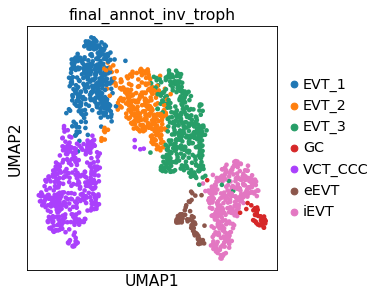

In [11]:
sc.pl.umap(adata, color = ['final_annot_inv_troph'],
          )

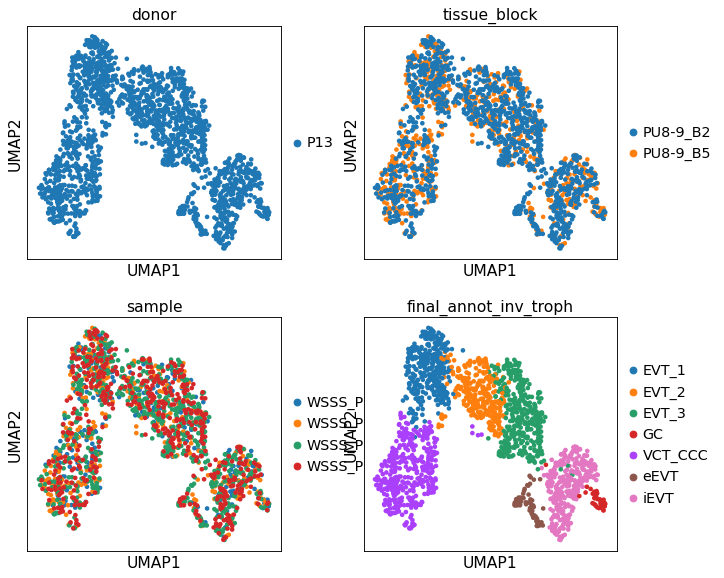

In [12]:
sc.pl.umap(adata, color = ['donor','tissue_block','sample','final_annot_inv_troph'], ncols=2)

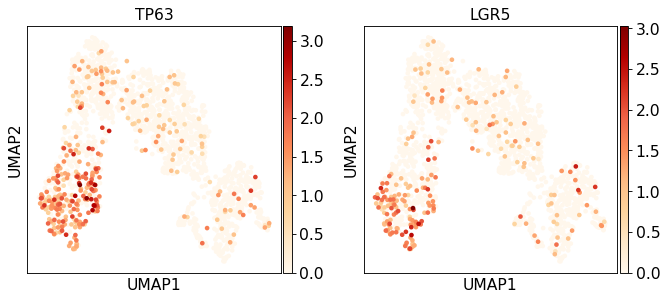

In [13]:
sc.pl.umap(adata, color = ['TP63','LGR5'], cmap='OrRd', use_raw=True)

## Choosing the root cell

LGR5+TP63+HLA-G-MKI67-

In [14]:
score_LGR5_TP63 = adata.raw[:,'LGR5'].X + adata.raw[:,'TP63'].X #- adata.raw[:,'HLA-G'].X - adata.raw[:,'MKI67'].X
score_LGR5_TP63 = score_LGR5_TP63.todense()

In [15]:
score_LGR5_TP63_HLAG_MKI67 = adata.raw[:,'LGR5'].X + adata.raw[:,'TP63'].X - adata.raw[:,'HLA-G'].X - adata.raw[:,'MKI67'].X
score_LGR5_TP63_HLAG_MKI67 = score_LGR5_TP63_HLAG_MKI67.todense()

In [16]:
adata.obs['root_score_+LGR5_+TP63'] = score_LGR5_TP63
adata.obs['root_score_+LGR5_+TP63_-HLA-G_-MKI67'] = score_LGR5_TP63_HLAG_MKI67

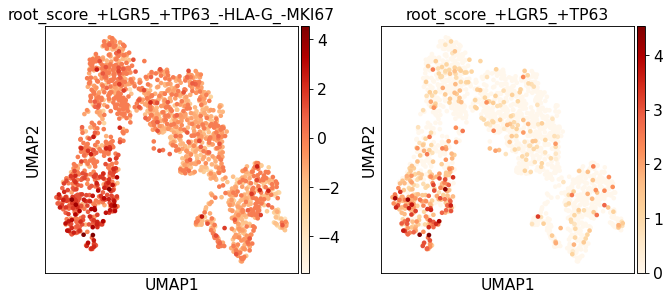

In [17]:
sc.pl.umap(adata, color=['root_score_+LGR5_+TP63_-HLA-G_-MKI67','root_score_+LGR5_+TP63'], cmap='OrRd', 
           #vmin = 0, 
           #vmax=7,
          )

In [18]:
np.argmax(adata.obs['root_score_+LGR5_+TP63'])

1399

In [19]:
np.argmax(adata.obs['root_score_+LGR5_+TP63_-HLA-G_-MKI67'])

1399

In [20]:
max(adata.obs['root_score_+LGR5_+TP63'])

4.5337371826171875

In [21]:
adata.obs['root_argmax_+LGR5_+TP63'] = np.argmax(adata.obs['root_score_+LGR5_+TP63'])#[1 if barcode == np.argmax(adata.obs['root_score_+LGR5_+TP63']) else 0 for barcode in list(adata.obs_names)]

In [22]:
adata.obs['root_argmax_+LGR5_+TP63_-HLA-G_-MKI67'] = np.argmax(adata.obs['root_score_+LGR5_+TP63_-HLA-G_-MKI67']) #[1 if barcode == np.argmax(adata.obs['root_score_+LGR5_+TP63_-HLA-G_-MKI67']) else 0 for barcode in list(adata.obs_names)]

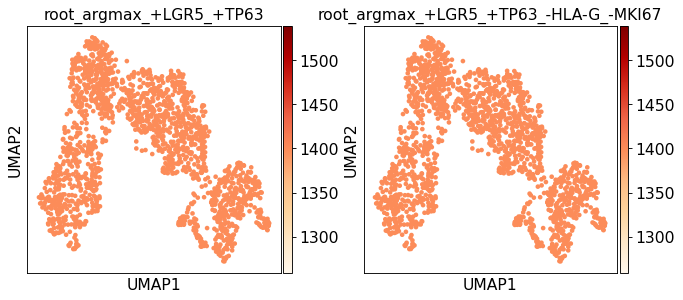

In [23]:
sc.pl.umap(adata, color=['root_argmax_+LGR5_+TP63','root_argmax_+LGR5_+TP63_-HLA-G_-MKI67'], cmap='OrRd', 
           #vmin = 0, 
           #vmax=7,
          )

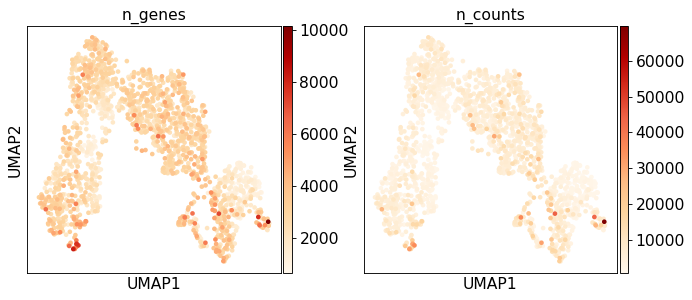

In [24]:
sc.pl.umap(adata, color=['n_genes','n_counts'], cmap='OrRd')

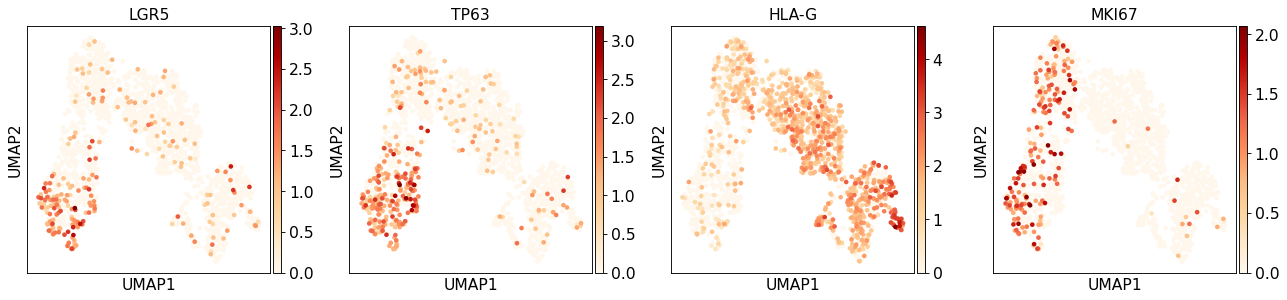

In [25]:
sc.pl.umap(adata, color=['LGR5','TP63','HLA-G','MKI67'], cmap='OrRd', use_raw=True)

In [26]:
rootcell = np.argmax(adata.obs['root_score_+LGR5_+TP63'])
adata.uns['iroot'] = rootcell
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1

In [27]:
adata.uns['iroot']

1399

In [28]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    u

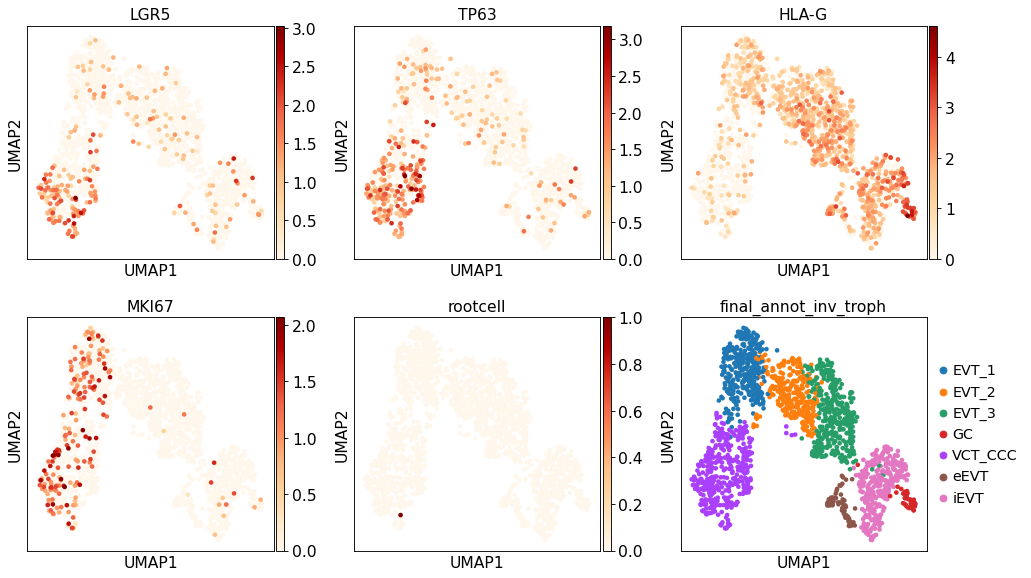

In [29]:
sc.pl.umap(adata,color=['LGR5','TP63','HLA-G','MKI67','rootcell','final_annot_inv_troph'], ncols=3, cmap='OrRd', use_raw=True)

## 1. Scanpy diffusion maps

In [30]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    u

In [31]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    u

In [32]:
rootcell = adata.uns['iroot']
adata.uns['iroot'] = rootcell

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9952855  0.98690534 0.97788715 0.96436083 0.9609315
     0.9554842  0.9501263  0.9421018  0.93699807 0.9288231  0.9281898
     0.92363304 0.91101617 0.909244  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


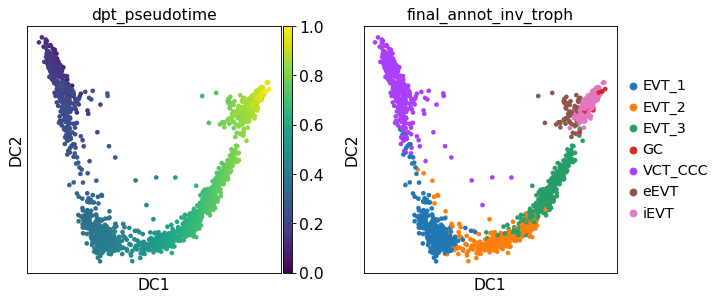

In [33]:
sc.tl.dpt(adata)
sc.pl.diffmap(adata,color=['dpt_pseudotime','final_annot_inv_troph'])

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


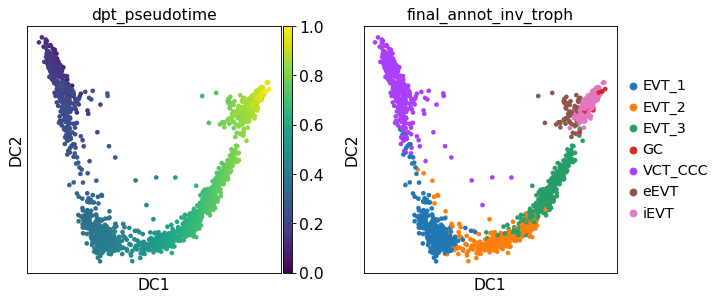

In [34]:
sc.tl.dpt(adata)
sc.pl.diffmap(adata,color=['dpt_pseudotime','final_annot_inv_troph'])

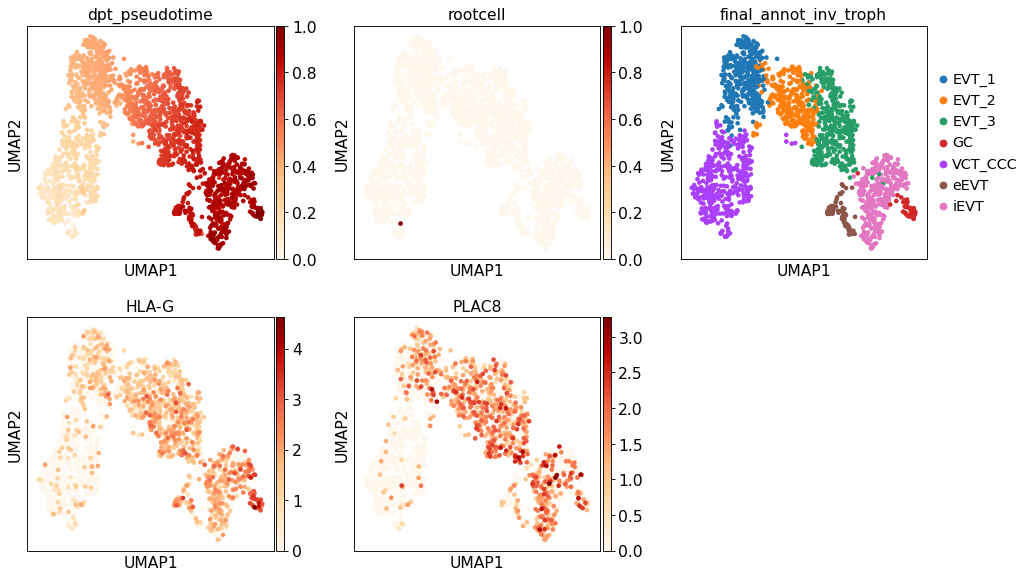

In [35]:
sc.pl.umap(adata,color=['dpt_pseudotime','rootcell','final_annot_inv_troph',
                       'HLA-G','PLAC8'], ncols=3, use_raw=True,
           cmap='OrRd')

## 2. Palantir

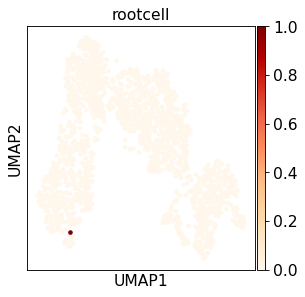

In [36]:
sc.pl.umap(adata,color='rootcell',color_map='OrRd')

In [37]:
colors_final = ['#d895ea', # EVT_1
               '#9f6bac', # EVT_2
               'purple', # EVT_3
               '#DBC7DE', # GC
               '#e7a3c8', # VCT_CCC
               'red', # eEVT
               'mediumvioletred', # iEVT
    
]


In [38]:
adata = sc.read(save_path+'adata_invading_trophoblast_with_trajectories_20201216.h5ad')

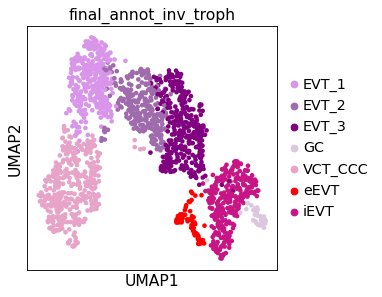

In [39]:
sc.pl.umap(adata, color='final_annot_inv_troph', palette=colors_final)

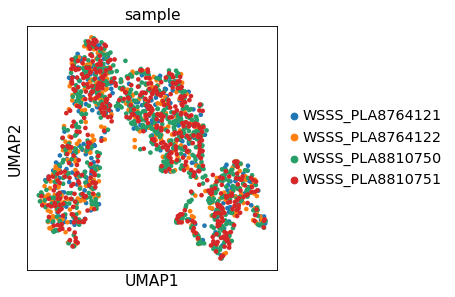

In [40]:
sc.pl.umap(adata, color='sample')

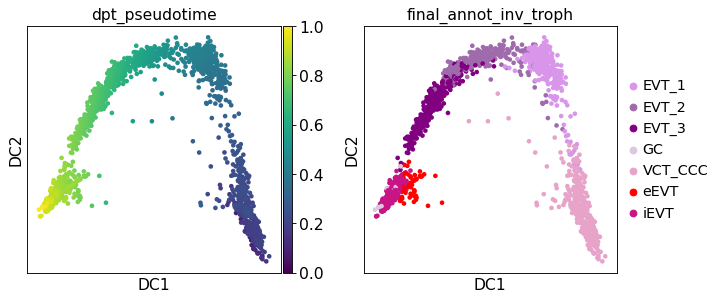

In [41]:
sc.pl.diffmap(adata,color=['dpt_pseudotime','final_annot_inv_troph'])

# goto notebook S2-3

In [42]:
adata = sc.read(save_path+'adata_invading_trophoblast_with_trajectories_20201216.h5ad')

In [47]:
sc.tl.diffmap(adata)
ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
pr_res = palantir.core.run_palantir(ms_data, adata.obs_names[rootcell], num_waypoints=500, knn=30)
adata.obs['palantir_pseudotime'] = pr_res.pseudotime

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9952855  0.98690534 0.97788715 0.96436083 0.9609315
     0.9554842  0.9501263  0.9421018  0.93699807 0.9288231  0.9281898
     0.92363304 0.91101617 0.909244  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


Sampling and flocking waypoints...
Time for determining waypoints: 0.002627428372701009 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.06488518317540487 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9938
Correlation at iteration 2: 0.9996
Correlation at iteration 3: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [48]:
sc.tl.dpt(adata, n_dcs=15)
sc.pl.umap(adata, color=['palantir_pseudotime', 'dpt_pseudotime'], save='_cluster_subset_pseudotime.pdf',
          cmap='OrRd')

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


In [49]:
sc.pl.diffmap(adata, color=['palantir_pseudotime', 'dpt_pseudotime'], 
              cmap='OrRd',
              save='_cluster_subset_pseudotime.pdf')

In [50]:
sc.pl.umap(adata, color=['palantir_pseudotime', 'dpt_pseudotime'], save='_cluster_subset_pseudotime.pdf',
          cmap='OrRd')

# I am going to use `dpt_pseudotime` metric for linear DE gene fitting - see notebook S13 in `../donor_P13_analysis/`

### 3. Monocle 3

In [51]:
%%bash

pip show rpy2

Name: rpy2
Version: 3.4.3
Summary: Python interface to the R language (embedded R)
Home-page: https://rpy2.github.io
Author: Laurent Gautier
Author-email: lgautier@gmail.com
License: GPLv2+
Location: /opt/conda/lib/python3.8/site-packages
Requires: pytz, tzlocal, jinja2, cffi
Required-by: palantir


In [53]:
%%bash

#pip show anndata2ri

In [76]:
import rpy2.rinterface_lib.callbacks
import logging
import rpy2
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri # requires 'pip install anndata2ri'
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
# Monocle3 complains about cells with zero total read count
np.unique(adata.obs['n_counts'])

array([  869.,   938.,   992., ..., 43576., 44477., 69698.], dtype=float32)

In [78]:
obs = adata.obs
umap = adata.obsm['X_umap']
expr_mtx = adata.X

In [79]:
umap

array([[ 3.3945663  ,  2.3026347  ],
       [-6.0186725  ,  0.022969361],
       [-7.425665   ,  2.497234   ],
       ...,
       [ 0.4677283  ,  3.2514842  ],
       [ 0.91333115 ,  3.506331   ],
       [-8.809008   , -1.8148025  ]], dtype=float32)

In [80]:
%%R

library(SingleCellExperiment)
library(monocle3)


In [81]:
%%R

sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] monocle3_1.0.0              SingleCellExperiment_1.12.0
 [3] SummarizedExperiment_1.20.0 Biobase_2.50.0             
 [5] GenomicRanges_1.42.0        GenomeInfoDb_1.26.4        
 [7] IRanges_2.24.1              S4Vectors_0.28.1           
 [9] BiocGenerics_0.36.0         MatrixGenerics_1.2.

In [82]:
%%R -i obs -i umap -i adata

X = matrix(0,nrow=1,ncol=dim(obs)[1])
mono = new_cell_data_set(X, cell_metadata=obs)
#mono = adata

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'anndata._core.anndata.AnnData'>'

In [63]:
%%R

head(obs)

R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': object 'obs' not found

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': object 'obs' not found


In [54]:
%%R

# trying another dataset from the web

# Load the data
expression_matrix <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_expression.rds"))
cell_metadata <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_colData.rds"))
gene_annotation <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_rowData.rds"))

# Make the CDS object
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)


Error in readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_expression.rds")) : 
  cannot read from connection


In [55]:
%%R

cds


Error in withVisible({ : object 'cds' not found


In [45]:
%%R -i obs -i umap -i adata

X = matrix(0,nrow=1,ncol=dim(obs)[1])
mono = new_cell_data_set(X, cell_metadata=obs)
#mono = adata

In [46]:
adata.obs

n_genes donor tissue_block      age           sample  \
AACAACCAGTCCTGCG-1       2486   P13     PU8-9_B5  8-9_PCW  WSSS_PLA8764121   
AACACACCACTGAGGA-1       2081   P13     PU8-9_B5  8-9_PCW  WSSS_PLA8764121   
AACCAACAGGTGGTTG-1       2721   P13     PU8-9_B5  8-9_PCW  WSSS_PLA8764121   
AACCATGCACTAAACC-1       1718   P13     PU8-9_B5  8-9_PCW  WSSS_PLA8764121   
AACCATGTCCAGCACG-1       1489   P13     PU8-9_B5  8-9_PCW  WSSS_PLA8764121   
...                       ...   ...          ...      ...              ...   
TTTACTGCATTGTAGC-1       3863   P13     PU8-9_B2  8-9_PCW  WSSS_PLA8810751   
TTTACTGTCTGCATGA-1       2917   P13     PU8-9_B2  8-9_PCW  WSSS_PLA8810751   
TTTATGCCAGATACCT-1       2361   P13     PU8-9_B2  8-9_PCW  WSSS_PLA8810751   
TTTGACTCAGGAATAT-1       3547   P13     PU8-9_B2  8-9_PCW  WSSS_PLA8810751   
TTTGGAGTCCACAAGT-1-1     2894   P13     PU8-9_B2  8-9_PCW  WSSS_PLA8810751   

                                          barcode_sample  percent_mito  \
AACAACCAGTCCTGCG-1    AACAACCAGTCCTGCG-1_WSSS_PLA8764121      0.000170   
AACACACCACTGAGGA-1    AACACACCACTGAGGA-1_WSSS_PLA8764121      0.000291   
AACCAACAGGTGGTTG-1    AACCAACAGGTGGTTG-1_WSSS_PLA8764121      0.000157   
AACCATGCACTAAACC-1    AACCATGCACTAAACC-1_WSSS_PLA8764121      0.000244   
AACCATGTCCAGCACG-1    AACCATGTCCAGCACG-1_WSSS_PLA8764121      0.001342   
...                                                  ...           ...   
TTTACTGCATTGTAGC-1    TTTACTGCATTGTAGC-1_WSSS_PLA8810751      0.000334   
TTTACTGTCTGCATGA-1    TTTACTGTCTGCATGA-1_WSSS_PLA8810751      0.001026   
TTTATGCCAGATACCT-1    TTTATGCCAGATACCT-1_WSSS_PLA8810751      0.001711   
TTTGACTCAGGAATAT-1    TTTGACTCAGGAATAT-1_WSSS_PLA8810751      0.000207   
TTTGGAGTCCACAAGT-1-1  TTTGGAGTCCACAAGT-1_WSSS_PLA8810751      0.000183   

                      n_counts    dataset technique  ...  louvain_R_2  \
AACAACCAGTCCTGCG-1      5877.0  snRNA-seq       10X  ...            1   
AACACACCACTGAGGA-1      3433.0  snRNA-seq       10X  ...            0   
AACCAACAGGTGGTTG-1      6351.0  snRNA-seq       10X  ...          2,0   
AACCATGCACTAAACC-1      4098.0  snRNA-seq       10X  ...            0   
AACCATGTCCAGCACG-1      2236.0  snRNA-seq       10X  ...            0   
...                        ...        ...       ...  ...          ...   
TTTACTGCATTGTAGC-1     11983.0  snRNA-seq       10X  ...            1   
TTTACTGTCTGCATGA-1      6823.0  snRNA-seq       10X  ...            4   
TTTATGCCAGATACCT-1      5259.0  snRNA-seq       10X  ...            4   
TTTGACTCAGGAATAT-1      9681.0  snRNA-seq       10X  ...            4   
TTTGGAGTCCACAAGT-1-1    5457.0  snRNA-seq       10X  ...            0   

                      prelim_annot_inv_troph  final_annot_inv_troph  \
AACAACCAGTCCTGCG-1               inv_troph_3                  EVT_3   
AACACACCACTGAGGA-1                   VCT_CCC                VCT_CCC   
AACCAACAGGTGGTTG-1                   VCT_CCC                  EVT_1   
AACCATGCACTAAACC-1                   VCT_CCC                VCT_CCC   
AACCATGTCCAGCACG-1                   VCT_CCC                VCT_CCC   
...                                      ...                    ...   
TTTACTGCATTGTAGC-1               inv_troph_3                  EVT_3   
TTTACTGTCTGCATGA-1               inv_troph_4                  EVT_2   
TTTATGCCAGATACCT-1               inv_troph_4                  EVT_2   
TTTGACTCAGGAATAT-1               inv_troph_3                  EVT_2   
TTTGGAGTCCACAAGT-1-1                 VCT_CCC                VCT_CCC   

                      root_score_+LGR5_+TP63  \
AACAACCAGTCCTGCG-1                  0.000000   
AACACACCACTGAGGA-1                  0.000000   
AACCAACAGGTGGTTG-1                  0.000000   
AACCATGCACTAAACC-1                  2.894890   
AACCATGTCCAGCACG-1                  1.699694   
...                                      ...   
TTTACTGCATTGTAGC-1                  0.606780   
TTTACTGTCTGCATGA-1                  0.000000   
TTTATGCCAGATACCT-1                

In [47]:
%%R
adata

TypeError: Indices must be integers or slices, not <class 'rpy2.robjects.vectors.StrVector'>

In [48]:
%%R

mono

class: cell_data_set 
dim: 1 1729 
metadata(1): cds_version
assays(1): counts
rownames: NULL
rowData names(0):
colnames(1729): AACAACCAGTCCTGCG-1 AACACACCACTGAGGA-1 ...
  TTTGACTCAGGAATAT-1 TTTGGAGTCCACAAGT-1-1
colData names(38): n_genes donor ... dpt_pseudotime palantir_pseudotime
reducedDimNames(0):
altExpNames(0):


In [49]:
%%R

expr_mtx <- assay(mono, "counts")


In [50]:
%%R

mono$counts <- expr_mtx

In [51]:
%%R

mono

class: cell_data_set 
dim: 1 1729 
metadata(1): cds_version
assays(1): counts
rownames: NULL
rowData names(0):
colnames(1729): AACAACCAGTCCTGCG-1 AACACACCACTGAGGA-1 ...
  TTTGACTCAGGAATAT-1 TTTGGAGTCCACAAGT-1-1
colData names(39): n_genes donor ... palantir_pseudotime counts
reducedDimNames(0):
altExpNames(0):


In [52]:
%%R

SimpleList(UMAP=umap)

List of length 1
names(1): UMAP


In [53]:
%%R

umap = as.matrix(umap)
rownames(umap) = rownames(obs)
mono@reducedDims = SimpleList(UMAP=umap)

#my_ensembl_gene_id <- row.names(expr_matrix)
#expr_matrix <- as.data.frame(lapply(expr_matrix, as.numeric))
#row.names(expr_matrix) <- my_ensembl_gene_id


Error in (function (cl, name, valueClass)  : 
  ‘reducedDims’ is not a slot in class “cell_data_set”


In [54]:
%%R

mono

class: cell_data_set 
dim: 1 1729 
metadata(1): cds_version
assays(1): counts
rownames: NULL
rowData names(0):
colnames(1729): AACAACCAGTCCTGCG-1 AACACACCACTGAGGA-1 ...
  TTTGACTCAGGAATAT-1 TTTGGAGTCCACAAGT-1-1
colData names(39): n_genes donor ... palantir_pseudotime counts
reducedDimNames(0):
altExpNames(0):


In [52]:
%%R

mono$reducedDims

List of length 1729
names(1729): UMAP UMAP UMAP UMAP UMAP UMAP ... UMAP UMAP UMAP UMAP UMAP UMAP


In [49]:
%%R

plot_cells(mono)


Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP before attempting to plot.


In [67]:
%%R

mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
plot_cells(mono,
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)

R[write to console]: Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP before running cluster_cells




Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP before running cluster_cells


In [43]:
%%R

mono = order_cells(mono)

R[write to console]: Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP, cluster_cells, and learn_graph before running order_cells.




Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP, cluster_cells, and learn_graph before running order_cells.


In [44]:
iroot = adata.obs_names[adata.uns['iroot']]

In [45]:
%%R -i iroot

mono = order_cells(mono, root_cells=iroot)

R[write to console]: Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP, cluster_cells, and learn_graph before running order_cells.




Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP, cluster_cells, and learn_graph before running order_cells.


In [46]:
%%R

plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           cell_size = 0.7,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

R[write to console]: Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP before attempting to plot.




Error: No dimensionality reduction for UMAP calculated. Please run reduce_dimension with reduction_method = UMAP before attempting to plot.


In [47]:
%%R -o pseudotime

pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime

In [48]:
pseudotime[:5]


TypeError: 'NULLType' object is not subscriptable

In [ ]:
adata.obs['pseudotime_monocle3'] = pseudotime

In [ ]:
sc.pl.umap(adata,color=['pseudotime_monocle3','dpt_pseudotime','palantir_pseudotime'], cmap='OrRd')

In [38]:
adata = sc.read(save_path+'adata_invading_trophoblast_with_trajectories_20201216.h5ad')

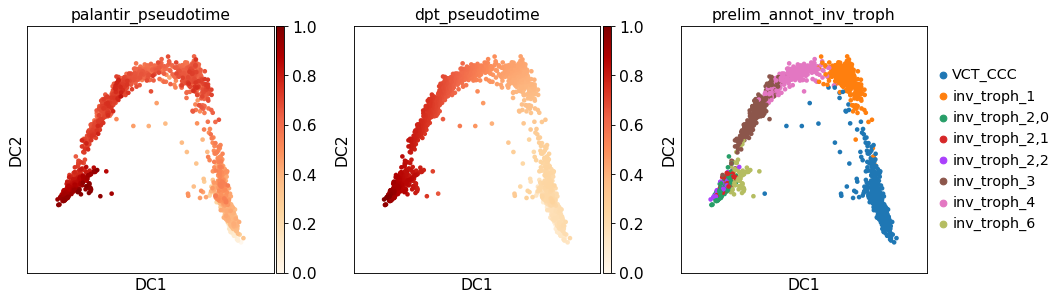

In [39]:
sc.pl.diffmap(adata, color=['palantir_pseudotime', 'dpt_pseudotime','prelim_annot_inv_troph'], 
              cmap='OrRd',
              save='_cluster_subset_pseudotime.pdf')

In [40]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [18]:
sc.tl.diffmap(adata)
ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
pr_res = palantir.core.run_palantir(ms_data, adata.obs_names[rootcell], num_waypoints=500, knn=30)
adata.obs['palantir_pseudotime'] = pr_res.pseudotime

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9996538  0.99871105 0.9966634  0.99393874 0.99310374
     0.9915729  0.98945993 0.9868984  0.9863087  0.985857   0.98414266
     0.98278886 0.9817682  0.9780101 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
Sampling and flocking waypoints...
Time for determining waypoints: 0.015751020113627116 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.792707335948944 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9835
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Pr

In [38]:
adata.uns['diffmap_evals']

array([1.        , 0.9996538 , 0.99871105, 0.9966634 , 0.99393874,
       0.99310374, 0.9915729 , 0.98945993, 0.9868984 , 0.9863087 ,
       0.985857  , 0.98414266, 0.98278886, 0.9817682 , 0.9780101 ],
      dtype=float32)

In [40]:
adata.obsm['X_diffmap'].shape

(26798, 15)

In [21]:
adata.raw

In [15]:
adata_palantir = sc.tl.palantir(adata, normalize=False, log_transform=False, filter_low=False, inplace=False)


AttributeError: module 'scanpy.api.tl' has no attribute 'palantir'

## 4. RNA velocity

In [52]:
np.unique(adata.obs['sample'])

array(['WSSS_PLA8764121', 'WSSS_PLA8764122', 'WSSS_PLA8810750',
       'WSSS_PLA8810751'], dtype=object)

In [53]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_analysis/'

In [44]:
%%time

loom_paths = {}

loom_paths['WSSS_PLA8764121'] = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202005_snRNA-seq_cellranger/snRNA_seq_data_MFI_blocks_from_prof_Moffett/cellranger302_count_33883_WSSS_PLA8764121_GRCh38-3_0_0-premrna/velocyto/possorted_genome_bam_7ZNK7.loom'
loom_paths['WSSS_PLA8764122'] = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202005_snRNA-seq_cellranger/snRNA_seq_data_MFI_blocks_from_prof_Moffett/cellranger302_count_33883_WSSS_PLA8764122_GRCh38-3_0_0-premrna/velocyto/possorted_genome_bam_V4O8B.loom'

loom_paths['WSSS_PLA8810750'] = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202006_snRNA-seq_MFI_paired_to_Visium_cellranger/cellranger302_count_34149_WSSS_PLA8810750_GRCh38-3_0_0_premrna/velocyto/possorted_genome_bam_PSPJC.loom'
loom_paths['WSSS_PLA8810751'] = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202006_snRNA-seq_MFI_paired_to_Visium_cellranger/cellranger302_count_34149_WSSS_PLA8810751_GRCh38-3_0_0_premrna/velocyto/possorted_genome_bam_T8XDM.loom'

looms = []
for sample in list(np.unique(adata.obs['sample'])):
    print(sample)
    looms.append(loom_paths[sample])

loompy.combine(looms, save_path + '20210317_velocyto_donor_P13.loom')

WSSS_PLA8764121
WSSS_PLA8764122
WSSS_PLA8810750
WSSS_PLA8810751


CPU times: user 23min 32s, sys: 3min 2s, total: 26min 34s
Wall time: 39min 6s


In [54]:
%%time
# takes about 25 minutes, but later faster
adata_loom = scv.read(save_path + '20210317_velocyto_donor_P13.loom', cache=True)

... reading from cache file cache/lustre-scratch117-cellgen-team292-aa22-adata_objects-202007_snRNA-seq_MFI-snRNA_seq_MFI_202007_adatas-202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants-donor_P13_analysis-20210317_velocyto_donor_P13.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 12.3 s, sys: 2.6 s, total: 14.9 s
Wall time: 1min 12s


In [103]:
adata_loom

AnnData object with n_obs × n_vars = 323369 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [104]:
adata_loom.obs.head()

Empty DataFrame
Columns: []
Index: [possorted_genome_bam_7ZNK7:AAACCCAAGATCACCT, possorted_genome_bam_7ZNK7:AAACCCAAGATCGCTT, possorted_genome_bam_7ZNK7:AAACCCAAGATACATG, possorted_genome_bam_7ZNK7:AAACCCAAGATTGCGG, possorted_genome_bam_7ZNK7:AAACCCAAGACGCTCC]

In [105]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime', 'root_cells_velocyto', 'end_points_velocyto'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells

In [106]:
len(adata.obs_names)

1729

In [107]:
adata_loom.obs_names

Index(['possorted_genome_bam_7ZNK7:AAACCCAAGATCACCT',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATCGCTT',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATACATG',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATTGCGG',
       'possorted_genome_bam_7ZNK7:AAACCCAAGACGCTCC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGAGTCAGC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGAGGATCC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCTCACTA',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCGTGCTC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCGGTAGT',
       ...
       'possorted_genome_bam_T8XDM:TTTGTTGTCCTCTCGA',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCAATTG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCCTGGCTT',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCTAGCG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGTAGCCG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCTTGCT',
       'possorted_genome_bam_T8XDM:TTTGTTGTCTGCGATA',
       'possorted_genome_bam_T8XDM:TTTGTTGTCTGGCTGG',
       'possorted

In [108]:
# dict of bam names to sample names
bam2sample = {}

bam2sample['possorted_genome_bam_7ZNK7'] = 'WSSS_PLA8764121'
bam2sample['possorted_genome_bam_V4O8B'] = 'WSSS_PLA8764122'
bam2sample['possorted_genome_bam_PSPJC'] = 'WSSS_PLA8810750'
bam2sample['possorted_genome_bam_T8XDM'] = 'WSSS_PLA8810751'



In [109]:
for barcode_sample in list(adata.obs['barcode_sample']):
    if '-1' not in barcode_sample:
        print(barcode_sample)

In [110]:
adata_loom

AnnData object with n_obs × n_vars = 323369 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [111]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime', 'root_cells_velocyto', 'end_points_velocyto'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells

In [112]:
# getting from the indices above to the ones in adata.obs['barcode_sample']
adata_loom.obs['barcode_sample_sn_like'] = [elem.split(':')[1] + '-1_' + bam2sample[elem.split(':')[0]] for elem in adata_loom.obs_names]

In [116]:
adata_loom.obs.set_index('barcode_sample_sn_like', inplace=True)
adata_loom.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGATCACCT-1_WSSS_PLA8764121, AAACCCAAGATCGCTT-1_WSSS_PLA8764121, AAACCCAAGATACATG-1_WSSS_PLA8764121, AAACCCAAGATTGCGG-1_WSSS_PLA8764121, AAACCCAAGACGCTCC-1_WSSS_PLA8764121, AAACCCAAGAGTCAGC-1_WSSS_PLA8764121, AAACCCAAGAGGATCC-1_WSSS_PLA8764121, AAACCCAAGCTCACTA-1_WSSS_PLA8764121, AAACCCAAGCGTGCTC-1_WSSS_PLA8764121, AAACCCAAGCGGTAGT-1_WSSS_PLA8764121, AAACCCAAGCTTTGTG-1_WSSS_PLA8764121, AAACCCAAGCCTGAGA-1_WSSS_PLA8764121, AAACCCAAGCGTGTTT-1_WSSS_PLA8764121, AAACCCAAGCTCGTGC-1_WSSS_PLA8764121, AAACCCAAGGCAATGC-1_WSSS_PLA8764121, AAACCCAAGTCTGTAC-1_WSSS_PLA8764121, AAACCCACAACACGTT-1_WSSS_PLA8764121, AAACCCAAGTTGGAAT-1_WSSS_PLA8764121, AAACCCACAACTGTGT-1_WSSS_PLA8764121, AAACCCACAACGATTC-1_WSSS_PLA8764121, AAACCCACAAATCCCA-1_WSSS_PLA8764121, AAACCCACAAGCTGCC-1_WSSS_PLA8764121, AAACCCACACAAGTGG-1_WSSS_PLA8764121, AAACCCACACAAAGTA-1_WSSS_PLA8764121, AAACCCACAATAGTCC-1_WSSS_PLA8764121, AAACCCACAAGTGGGT-1_WSSS_PLA8764121, AAACCCACAAGTGGCA-1_WSSS_PLA8764121, AAACCCACAGACCAAG-1_WSSS_PLA8764121, AAACCCACACCAGCGT-1_WSSS_PLA8764121, AAACCCACACGCTATA-1_WSSS_PLA8764121, AAACCCACACTCAGAT-1_WSSS_PLA8764121, AAACCCACACCATATG-1_WSSS_PLA8764121, AAACCCACAGTTTCGA-1_WSSS_PLA8764121, AAACCCACATAACCCA-1_WSSS_PLA8764121, AAACCCACAGGTGAGT-1_WSSS_PLA8764121, AAACCCACAGGTGGAT-1_WSSS_PLA8764121, AAACCCACAGGCGATA-1_WSSS_PLA8764121, AAACCCAGTAAGTAGT-1_WSSS_PLA8764121, AAACCCACATGGCCAC-1_WSSS_PLA8764121, AAACCCACATGCACTA-1_WSSS_PLA8764121, AAACCCAGTAACACGG-1_WSSS_PLA8764121, AAACCCACATGGCTGC-1_WSSS_PLA8764121, AAACCCACATCCAATG-1_WSSS_PLA8764121, AAACCCACATGACTCA-1_WSSS_PLA8764121, AAACCCAGTACCATAC-1_WSSS_PLA8764121, AAACCCAGTCCTACAA-1_WSSS_PLA8764121, AAACCCAGTATGCAAA-1_WSSS_PLA8764121, AAACCCAGTAGTCGGA-1_WSSS_PLA8764121, AAACCCAGTCGTTCAA-1_WSSS_PLA8764121, AAACCCAGTGACAACG-1_WSSS_PLA8764121, AAACCCAGTGAGCTCC-1_WSSS_PLA8764121, AAACCCAGTCGTTATG-1_WSSS_PLA8764121, AAACCCAGTGCACATT-1_WSSS_PLA8764121, AAACCCAGTCTTCCGT-1_WSSS_PLA8764121, AAACCCAGTGGCAACA-1_WSSS_PLA8764121, AAACCCAGTGTAGGAC-1_WSSS_PLA8764121, AAACCCAGTGTTACTG-1_WSSS_PLA8764121, AAACCCAGTTCCCACT-1_WSSS_PLA8764121, AAACCCAGTTCAGTAC-1_WSSS_PLA8764121, AAACCCAGTGTTACAC-1_WSSS_PLA8764121, AAACCCAGTTCGCGTG-1_WSSS_PLA8764121, AAACCCAGTTGTTGTG-1_WSSS_PLA8764121, AAACCCAGTGTTTCTT-1_WSSS_PLA8764121, AAACCCAGTTGACTGT-1_WSSS_PLA8764121, AAACCCAGTTATGGTC-1_WSSS_PLA8764121, AAACCCATCATCACTT-1_WSSS_PLA8764121, AAACCCATCATTTCGT-1_WSSS_PLA8764121, AAACCCATCACCTCGT-1_WSSS_PLA8764121, AAACCCATCATAGACC-1_WSSS_PLA8764121, AAACCCATCACCTACC-1_WSSS_PLA8764121, AAACCCATCAGAGCGA-1_WSSS_PLA8764121, AAACCCATCCGGTTCT-1_WSSS_PLA8764121, AAACCCATCCCTTCCC-1_WSSS_PLA8764121, AAACCCATCCGTAGTA-1_WSSS_PLA8764121, AAACCCATCGATACAC-1_WSSS_PLA8764121, AAACCCATCCTGCTAC-1_WSSS_PLA8764121, AAACCCATCCCTCTCC-1_WSSS_PLA8764121, AAACCCATCCTTCACG-1_WSSS_PLA8764121, AAACCCATCCATCAGA-1_WSSS_PLA8764121, AAACCCATCCGCATAA-1_WSSS_PLA8764121, AAACCCATCCGCACGA-1_WSSS_PLA8764121, AAACCCATCTAACGGT-1_WSSS_PLA8764121, AAACCCATCTCAGGCG-1_WSSS_PLA8764121, AAACCCATCTCACCCA-1_WSSS_PLA8764121, AAACCCATCGTCAAAC-1_WSSS_PLA8764121, AAACCCATCGGTGTAT-1_WSSS_PLA8764121, AAACCCATCGGCTGAC-1_WSSS_PLA8764121, AAACCCATCGTGACTA-1_WSSS_PLA8764121, AAACCCATCGGTGAAG-1_WSSS_PLA8764121, AAACCCATCTTGGCTC-1_WSSS_PLA8764121, AAACCCATCTTGGGCG-1_WSSS_PLA8764121, AAACCCATCTGCATGA-1_WSSS_PLA8764121, AAACCCATCTGAGTCA-1_WSSS_PLA8764121, AAACCCATCTCCGAAA-1_WSSS_PLA8764121, AAACGAAAGAGAACCC-1_WSSS_PLA8764121, AAACGAAAGAGCAGAA-1_WSSS_PLA8764121, AAACGAAAGAGTCGAC-1_WSSS_PLA8764121, AAACGAAAGCATCCCG-1_WSSS_PLA8764121, AAACGAAAGCCGGAAT-1_WSSS_PLA8764121, AAACGAAAGAGAGAAC-1_WSSS_PLA8764121, ...]

[323369 rows x 0 columns]

In [52]:
#adata_loom.obs_names = [i.split(':')[1] for i in adata_loom.obs_names]

In [117]:
adata_loom.obs_names_make_unique()

In [118]:
adata_loom.obs_names

Index(['AAACCCAAGATCACCT-1_WSSS_PLA8764121',
       'AAACCCAAGATCGCTT-1_WSSS_PLA8764121',
       'AAACCCAAGATACATG-1_WSSS_PLA8764121',
       'AAACCCAAGATTGCGG-1_WSSS_PLA8764121',
       'AAACCCAAGACGCTCC-1_WSSS_PLA8764121',
       'AAACCCAAGAGTCAGC-1_WSSS_PLA8764121',
       'AAACCCAAGAGGATCC-1_WSSS_PLA8764121',
       'AAACCCAAGCTCACTA-1_WSSS_PLA8764121',
       'AAACCCAAGCGTGCTC-1_WSSS_PLA8764121',
       'AAACCCAAGCGGTAGT-1_WSSS_PLA8764121',
       ...
       'TTTGTTGTCCTCTCGA-1_WSSS_PLA8810751',
       'TTTGTTGTCGCAATTG-1_WSSS_PLA8810751',
       'TTTGTTGTCCTGGCTT-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTAGCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGTAGCCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTTGCT-1_WSSS_PLA8810751',
       'TTTGTTGTCTGCGATA-1_WSSS_PLA8810751',
       'TTTGTTGTCTGGCTGG-1_WSSS_PLA8810751',
       'TTTGTTGTCTTAGTTC-1_WSSS_PLA8810751',
       'TTTGTTGTCTTCGGTC-1_WSSS_PLA8810751'],
      dtype='object', name='barcode_sample_sn_like', length=323369)

In [119]:
adata_loom = adata_loom[[i for i in adata.obs['barcode_sample']]].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [117]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 33538
    obs: 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [118]:
adata_loom.var_names_make_unique()
adata_loom.obs_names_make_unique()

In [119]:
scv.pp.show_proportions(adata_loom)
scv.pp.cleanup(adata_loom, clean='all')

Abundance of ['spliced', 'unspliced']: [0.19 0.81]


In [120]:
adata_loom.layers['spliced']

<1729x33538 sparse matrix of type '<class 'numpy.uint32'>'
	with 1252739 stored elements in Compressed Sparse Row format>

In [121]:
adata_loom.layers['unspliced']

<1729x33538 sparse matrix of type '<class 'numpy.uint32'>'
	with 3397225 stored elements in Compressed Sparse Row format>

In [122]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 33538
    layers: 'spliced', 'unspliced'

In [123]:
adata_loom.obs['n_counts_spliced'] = adata_loom.layers['spliced'].sum(1)

In [124]:
adata_loom.obs['n_counts_unspliced'] = adata_loom.layers['unspliced'].sum(1)

In [125]:
np.unique(adata_loom.obs['n_counts_spliced'])

array([  165,   168,   172, ..., 11745, 14689, 43784], dtype=uint64)

In [126]:
np.unique(adata_loom.obs['n_counts_unspliced'])

array([  335,   501,   544, ..., 27642, 28175, 32131], dtype=uint64)

In [127]:
adata_loom.var_names_make_unique()
scv.pp.filter_and_normalize(adata_loom, min_counts=20, 
                            #min_counts_u=10, 
                            n_top_genes=4000)

Filtered out 24363 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.


In [128]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 4000
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'spliced', 'unspliced'

In [129]:
scv.pp.moments(adata_loom)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [130]:
%%time
scv.tl.velocity(adata_loom)
scv.tl.velocity_graph(adata_loom)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
CPU times: user 2.83 s, sys: 58.7 ms, total: 2.88 s
Wall time: 2.89 s


In [131]:
scv.tl.louvain(adata_loom, resolution=0.6)
scv.tl.velocity_embedding(adata_loom, basis='pca')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


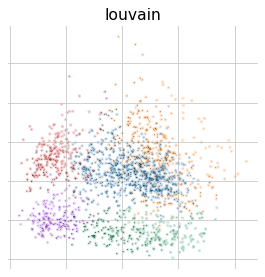

In [132]:
scv.pl.velocity_embedding(adata_loom, basis='pca')

In [133]:
scv.tl.terminal_states(adata_loom) # rerun

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [134]:
adata_loom.obs.columns

Index(['n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced',
       'initial_size_unspliced', 'initial_size', 'n_counts',
       'velocity_self_transition', 'louvain', 'root_cells', 'end_points'],
      dtype='object')

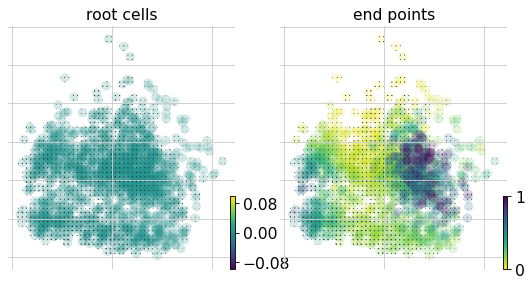

In [135]:
scv.pl.velocity_embedding_grid(adata_loom, basis='pca', color=['root_cells', 'end_points'])

In [136]:
adata_loom.obsm['X_umap'] = adata.obsm['X_umap']

In [137]:
scv.tl.velocity_embedding(adata_loom, basis='umap')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


In [141]:
scv.tl.terminal_states(adata_loom)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:58) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


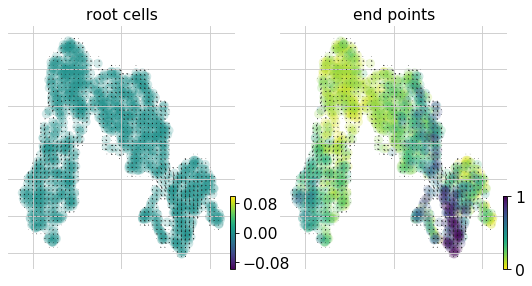

In [142]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scv.pl.velocity_embedding_grid(adata_loom, basis='umap', color=['root_cells', 'end_points'])

In [144]:
scv.tl.umap(adata_loom)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:49) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


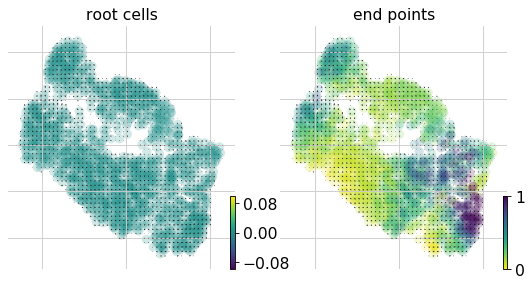

In [145]:
scv.tl.velocity_embedding(adata_loom, basis='umap')
scv.tl.terminal_states(adata_loom)
scv.pl.velocity_embedding_grid(adata_loom, basis='umap', color=['root_cells', 'end_points'])

In [146]:
adata_loom.obs

n_counts_spliced  n_counts_unspliced  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121               708                4643   
AACACACCACTGAGGA-1_WSSS_PLA8764121               538                2588   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121               919                4928   
AACCATGCACTAAACC-1_WSSS_PLA8764121               514                3316   
AACCATGTCCAGCACG-1_WSSS_PLA8764121               344                1709   
...                                              ...                 ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751              1903                9059   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751              1007                5238   
TTTATGCCAGATACCT-1_WSSS_PLA8810751               784                4088   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751              1330                7496   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751               741                4294   

                                    initial_size_spliced  \
barcode_sample_sn_like                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                   708   
AACACACCACTGAGGA-1_WSSS_PLA8764121                   538   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                   919   
AACCATGCACTAAACC-1_WSSS_PLA8764121                   514   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                   344   
...                                                  ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                  1903   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                  1007   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                   784   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                  1330   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                   741   

                                    initial_size_unspliced  initial_size  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                    4643         708.0   
AACACACCACTGAGGA-1_WSSS_PLA8764121                    2588         538.0   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                    4928         919.0   
AACCATGCACTAAACC-1_WSSS_PLA8764121                    3316         514.0   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                    1709         344.0   
...                                                    ...           ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                    9059        1903.0   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                    5238        1007.0   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                    4088         784.0   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                    7496        1330.0   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                    4294         741.0   

                                      n_counts  velocity_self_transition  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121  862.067810                  0.077434   
AACACACCACTGAGGA-1_WSSS_PLA8764121  844.293579                  0.348836   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121  856.087036                  0.131639   
AACCATGCACTAAACC-1_WSSS_PLA8764121  847.681030                  0.246179   
AACCATGTCCAGCACG-1_WSSS_PLA8764121  838.412842                  0.176096   
...                                        ...                       ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751  866.705200                  0.215555   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751  853.096313                  0.088361   
TTTATGCCAGATACCT-1_WSSS_PLA8810751  869.625000                  0.090821   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751  858.789368                  0.167634   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751  855.813843                  0.207655   

                                   louvain  root_cells  end_points  
barcode_sample_sn_like                                              
AACAACCAGTCCTGCG-1_WSSS_PLA8764121       2         0.0    0.361075  
AACACACCACTGAGGA-1_WSSS_PLA8764121       4         0.0    0.379664  
AACCAACAGGTG

In [147]:
adata.obs['root_cells_velocyto'] = list(adata_loom.obs['root_cells'])
adata.obs['end_points_velocyto'] = list(adata_loom.obs['end_points'])

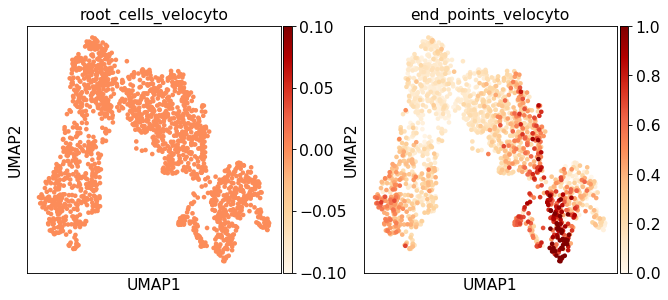

In [148]:
sc.pl.umap(adata, color=['root_cells_velocyto','end_points_velocyto'], cmap='OrRd')

In [149]:
adata_loom.obs

n_counts_spliced  n_counts_unspliced  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121               708                4643   
AACACACCACTGAGGA-1_WSSS_PLA8764121               538                2588   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121               919                4928   
AACCATGCACTAAACC-1_WSSS_PLA8764121               514                3316   
AACCATGTCCAGCACG-1_WSSS_PLA8764121               344                1709   
...                                              ...                 ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751              1903                9059   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751              1007                5238   
TTTATGCCAGATACCT-1_WSSS_PLA8810751               784                4088   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751              1330                7496   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751               741                4294   

                                    initial_size_spliced  \
barcode_sample_sn_like                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                   708   
AACACACCACTGAGGA-1_WSSS_PLA8764121                   538   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                   919   
AACCATGCACTAAACC-1_WSSS_PLA8764121                   514   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                   344   
...                                                  ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                  1903   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                  1007   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                   784   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                  1330   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                   741   

                                    initial_size_unspliced  initial_size  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                    4643         708.0   
AACACACCACTGAGGA-1_WSSS_PLA8764121                    2588         538.0   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                    4928         919.0   
AACCATGCACTAAACC-1_WSSS_PLA8764121                    3316         514.0   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                    1709         344.0   
...                                                    ...           ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                    9059        1903.0   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                    5238        1007.0   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                    4088         784.0   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                    7496        1330.0   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                    4294         741.0   

                                      n_counts  velocity_self_transition  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121  862.067810                  0.077434   
AACACACCACTGAGGA-1_WSSS_PLA8764121  844.293579                  0.348836   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121  856.087036                  0.131639   
AACCATGCACTAAACC-1_WSSS_PLA8764121  847.681030                  0.246179   
AACCATGTCCAGCACG-1_WSSS_PLA8764121  838.412842                  0.176096   
...                                        ...                       ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751  866.705200                  0.215555   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751  853.096313                  0.088361   
TTTATGCCAGATACCT-1_WSSS_PLA8810751  869.625000                  0.090821   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751  858.789368                  0.167634   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751  855.813843                  0.207655   

                                   louvain  root_cells  end_points  
barcode_sample_sn_like                                              
AACAACCAGTCCTGCG-1_WSSS_PLA8764121       2         0.0    0.361075  
AACACACCACTGAGGA-1_WSSS_PLA8764121       4         0.0    0.379664  
AACCAACAGGTG

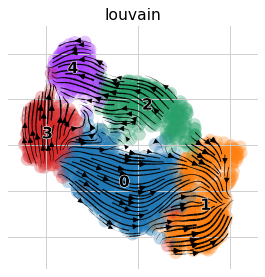

In [151]:
scv.pl.velocity_embedding_stream(adata_loom, basis='umap')


In [152]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 4000
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain', 'root_cells', 'end_points'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'velocity_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

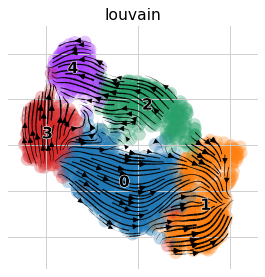

In [153]:
scv.pl.velocity_embedding_stream(adata_loom, basis='X_umap')


In [155]:
adata_loom.obs['cell_type'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'final_annot_inv_troph']

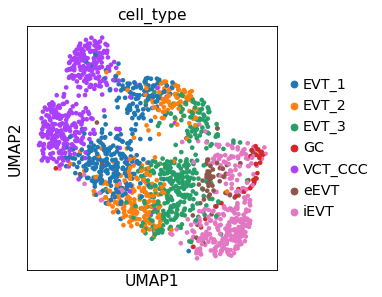

In [156]:
sc.pl.umap(adata_loom, color='cell_type')

In [160]:
adata_loom.obs['sample'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'sample']
adata_loom.obs['tissue_block'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'tissue_block']

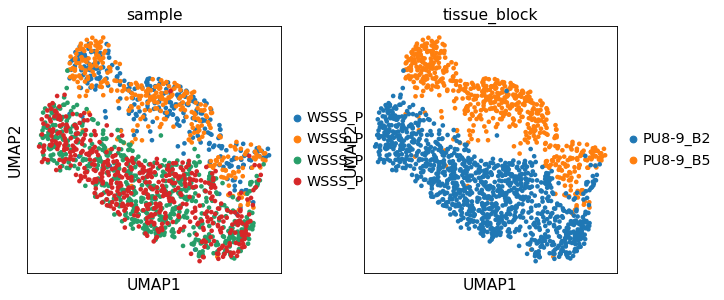

In [162]:
sc.pl.umap(adata_loom, color=['sample','tissue_block'])

In [163]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 4000
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain', 'root_cells', 'end_points', 'cell_type', 'sample', 'tissue_block'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors', 'umap', 'cell_type_colors', 'sample_colors', 'tissue_block_colors'
    obsm: 'X_pca', 'velocity_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

# Looking at RNA velocity results on a per-sample basis

In [149]:
%%time
# takes about 25 minutes, but later faster
adata_loom = scv.read(save_path + '20210317_velocyto_donor_P13.loom', cache=True)

... reading from cache file cache/lustre-scratch117-cellgen-team292-aa22-adata_objects-202007_snRNA-seq_MFI-snRNA_seq_MFI_202007_adatas-202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants-donor_P13_analysis-20210317_velocyto_donor_P13.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 11.2 s, sys: 2.19 s, total: 13.4 s
Wall time: 13.4 s


In [150]:
adata_loom

AnnData object with n_obs × n_vars = 323369 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [151]:
adata_loom.obs.head()

Empty DataFrame
Columns: []
Index: [possorted_genome_bam_7ZNK7:AAACCCAAGATCACCT, possorted_genome_bam_7ZNK7:AAACCCAAGATCGCTT, possorted_genome_bam_7ZNK7:AAACCCAAGATACATG, possorted_genome_bam_7ZNK7:AAACCCAAGATTGCGG, possorted_genome_bam_7ZNK7:AAACCCAAGACGCTCC]

In [152]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['WSSS_PLA8764121', 'WSSS_PLA8764122', 'WSSS_PLA8810750',
        'WSSS_PLA8810751'], dtype=object),
 array([272, 326, 606, 525]))

In [153]:
len(adata.obs_names)

1729

In [154]:
adata_loom.obs_names

Index(['possorted_genome_bam_7ZNK7:AAACCCAAGATCACCT',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATCGCTT',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATACATG',
       'possorted_genome_bam_7ZNK7:AAACCCAAGATTGCGG',
       'possorted_genome_bam_7ZNK7:AAACCCAAGACGCTCC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGAGTCAGC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGAGGATCC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCTCACTA',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCGTGCTC',
       'possorted_genome_bam_7ZNK7:AAACCCAAGCGGTAGT',
       ...
       'possorted_genome_bam_T8XDM:TTTGTTGTCCTCTCGA',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCAATTG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCCTGGCTT',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCTAGCG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGTAGCCG',
       'possorted_genome_bam_T8XDM:TTTGTTGTCGCTTGCT',
       'possorted_genome_bam_T8XDM:TTTGTTGTCTGCGATA',
       'possorted_genome_bam_T8XDM:TTTGTTGTCTGGCTGG',
       'possorted

In [155]:
# dict of bam names to sample names
bam2sample = {}

bam2sample['possorted_genome_bam_7ZNK7'] = 'WSSS_PLA8764121'
bam2sample['possorted_genome_bam_V4O8B'] = 'WSSS_PLA8764122'
bam2sample['possorted_genome_bam_PSPJC'] = 'WSSS_PLA8810750'
bam2sample['possorted_genome_bam_T8XDM'] = 'WSSS_PLA8810751'



In [156]:
for barcode_sample in list(adata.obs['barcode_sample']):
    if '-1' not in barcode_sample:
        print(barcode_sample)

In [157]:
adata_loom

AnnData object with n_obs × n_vars = 323369 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [158]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [159]:
# getting from the indices above to the ones in adata.obs['barcode_sample']
adata_loom.obs['barcode_sample_sn_like'] = [elem.split(':')[1] + '-1_' + bam2sample[elem.split(':')[0]] for elem in adata_loom.obs_names]

In [160]:
adata_loom.obs.set_index('barcode_sample_sn_like', inplace=True)
adata_loom.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGATCACCT-1_WSSS_PLA8764121, AAACCCAAGATCGCTT-1_WSSS_PLA8764121, AAACCCAAGATACATG-1_WSSS_PLA8764121, AAACCCAAGATTGCGG-1_WSSS_PLA8764121, AAACCCAAGACGCTCC-1_WSSS_PLA8764121, AAACCCAAGAGTCAGC-1_WSSS_PLA8764121, AAACCCAAGAGGATCC-1_WSSS_PLA8764121, AAACCCAAGCTCACTA-1_WSSS_PLA8764121, AAACCCAAGCGTGCTC-1_WSSS_PLA8764121, AAACCCAAGCGGTAGT-1_WSSS_PLA8764121, AAACCCAAGCTTTGTG-1_WSSS_PLA8764121, AAACCCAAGCCTGAGA-1_WSSS_PLA8764121, AAACCCAAGCGTGTTT-1_WSSS_PLA8764121, AAACCCAAGCTCGTGC-1_WSSS_PLA8764121, AAACCCAAGGCAATGC-1_WSSS_PLA8764121, AAACCCAAGTCTGTAC-1_WSSS_PLA8764121, AAACCCACAACACGTT-1_WSSS_PLA8764121, AAACCCAAGTTGGAAT-1_WSSS_PLA8764121, AAACCCACAACTGTGT-1_WSSS_PLA8764121, AAACCCACAACGATTC-1_WSSS_PLA8764121, AAACCCACAAATCCCA-1_WSSS_PLA8764121, AAACCCACAAGCTGCC-1_WSSS_PLA8764121, AAACCCACACAAGTGG-1_WSSS_PLA8764121, AAACCCACACAAAGTA-1_WSSS_PLA8764121, AAACCCACAATAGTCC-1_WSSS_PLA8764121, AAACCCACAAGTGGGT-1_WSSS_PLA8764121, AAACCCACAAGTGGCA-1_WSSS_PLA8764121, AAACCCACAGACCAAG-1_WSSS_PLA8764121, AAACCCACACCAGCGT-1_WSSS_PLA8764121, AAACCCACACGCTATA-1_WSSS_PLA8764121, AAACCCACACTCAGAT-1_WSSS_PLA8764121, AAACCCACACCATATG-1_WSSS_PLA8764121, AAACCCACAGTTTCGA-1_WSSS_PLA8764121, AAACCCACATAACCCA-1_WSSS_PLA8764121, AAACCCACAGGTGAGT-1_WSSS_PLA8764121, AAACCCACAGGTGGAT-1_WSSS_PLA8764121, AAACCCACAGGCGATA-1_WSSS_PLA8764121, AAACCCAGTAAGTAGT-1_WSSS_PLA8764121, AAACCCACATGGCCAC-1_WSSS_PLA8764121, AAACCCACATGCACTA-1_WSSS_PLA8764121, AAACCCAGTAACACGG-1_WSSS_PLA8764121, AAACCCACATGGCTGC-1_WSSS_PLA8764121, AAACCCACATCCAATG-1_WSSS_PLA8764121, AAACCCACATGACTCA-1_WSSS_PLA8764121, AAACCCAGTACCATAC-1_WSSS_PLA8764121, AAACCCAGTCCTACAA-1_WSSS_PLA8764121, AAACCCAGTATGCAAA-1_WSSS_PLA8764121, AAACCCAGTAGTCGGA-1_WSSS_PLA8764121, AAACCCAGTCGTTCAA-1_WSSS_PLA8764121, AAACCCAGTGACAACG-1_WSSS_PLA8764121, AAACCCAGTGAGCTCC-1_WSSS_PLA8764121, AAACCCAGTCGTTATG-1_WSSS_PLA8764121, AAACCCAGTGCACATT-1_WSSS_PLA8764121, AAACCCAGTCTTCCGT-1_WSSS_PLA8764121, AAACCCAGTGGCAACA-1_WSSS_PLA8764121, AAACCCAGTGTAGGAC-1_WSSS_PLA8764121, AAACCCAGTGTTACTG-1_WSSS_PLA8764121, AAACCCAGTTCCCACT-1_WSSS_PLA8764121, AAACCCAGTTCAGTAC-1_WSSS_PLA8764121, AAACCCAGTGTTACAC-1_WSSS_PLA8764121, AAACCCAGTTCGCGTG-1_WSSS_PLA8764121, AAACCCAGTTGTTGTG-1_WSSS_PLA8764121, AAACCCAGTGTTTCTT-1_WSSS_PLA8764121, AAACCCAGTTGACTGT-1_WSSS_PLA8764121, AAACCCAGTTATGGTC-1_WSSS_PLA8764121, AAACCCATCATCACTT-1_WSSS_PLA8764121, AAACCCATCATTTCGT-1_WSSS_PLA8764121, AAACCCATCACCTCGT-1_WSSS_PLA8764121, AAACCCATCATAGACC-1_WSSS_PLA8764121, AAACCCATCACCTACC-1_WSSS_PLA8764121, AAACCCATCAGAGCGA-1_WSSS_PLA8764121, AAACCCATCCGGTTCT-1_WSSS_PLA8764121, AAACCCATCCCTTCCC-1_WSSS_PLA8764121, AAACCCATCCGTAGTA-1_WSSS_PLA8764121, AAACCCATCGATACAC-1_WSSS_PLA8764121, AAACCCATCCTGCTAC-1_WSSS_PLA8764121, AAACCCATCCCTCTCC-1_WSSS_PLA8764121, AAACCCATCCTTCACG-1_WSSS_PLA8764121, AAACCCATCCATCAGA-1_WSSS_PLA8764121, AAACCCATCCGCATAA-1_WSSS_PLA8764121, AAACCCATCCGCACGA-1_WSSS_PLA8764121, AAACCCATCTAACGGT-1_WSSS_PLA8764121, AAACCCATCTCAGGCG-1_WSSS_PLA8764121, AAACCCATCTCACCCA-1_WSSS_PLA8764121, AAACCCATCGTCAAAC-1_WSSS_PLA8764121, AAACCCATCGGTGTAT-1_WSSS_PLA8764121, AAACCCATCGGCTGAC-1_WSSS_PLA8764121, AAACCCATCGTGACTA-1_WSSS_PLA8764121, AAACCCATCGGTGAAG-1_WSSS_PLA8764121, AAACCCATCTTGGCTC-1_WSSS_PLA8764121, AAACCCATCTTGGGCG-1_WSSS_PLA8764121, AAACCCATCTGCATGA-1_WSSS_PLA8764121, AAACCCATCTGAGTCA-1_WSSS_PLA8764121, AAACCCATCTCCGAAA-1_WSSS_PLA8764121, AAACGAAAGAGAACCC-1_WSSS_PLA8764121, AAACGAAAGAGCAGAA-1_WSSS_PLA8764121, AAACGAAAGAGTCGAC-1_WSSS_PLA8764121, AAACGAAAGCATCCCG-1_WSSS_PLA8764121, AAACGAAAGCCGGAAT-1_WSSS_PLA8764121, AAACGAAAGAGAGAAC-1_WSSS_PLA8764121, ...]

[323369 rows x 0 columns]

In [161]:
adata_loom.obs_names_make_unique()

In [162]:
adata_loom.obs_names

Index(['AAACCCAAGATCACCT-1_WSSS_PLA8764121',
       'AAACCCAAGATCGCTT-1_WSSS_PLA8764121',
       'AAACCCAAGATACATG-1_WSSS_PLA8764121',
       'AAACCCAAGATTGCGG-1_WSSS_PLA8764121',
       'AAACCCAAGACGCTCC-1_WSSS_PLA8764121',
       'AAACCCAAGAGTCAGC-1_WSSS_PLA8764121',
       'AAACCCAAGAGGATCC-1_WSSS_PLA8764121',
       'AAACCCAAGCTCACTA-1_WSSS_PLA8764121',
       'AAACCCAAGCGTGCTC-1_WSSS_PLA8764121',
       'AAACCCAAGCGGTAGT-1_WSSS_PLA8764121',
       ...
       'TTTGTTGTCCTCTCGA-1_WSSS_PLA8810751',
       'TTTGTTGTCGCAATTG-1_WSSS_PLA8810751',
       'TTTGTTGTCCTGGCTT-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTAGCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGTAGCCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTTGCT-1_WSSS_PLA8810751',
       'TTTGTTGTCTGCGATA-1_WSSS_PLA8810751',
       'TTTGTTGTCTGGCTGG-1_WSSS_PLA8810751',
       'TTTGTTGTCTTAGTTC-1_WSSS_PLA8810751',
       'TTTGTTGTCTTCGGTC-1_WSSS_PLA8810751'],
      dtype='object', name='barcode_sample_sn_like', length=323369)

In [163]:
adata_loom = adata_loom[[i for i in adata.obs['barcode_sample']]].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [164]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [165]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [166]:
adata.obs.set_index('barcode_sample').loc[adata_loom.obs.index,'sample']

barcode_sample_sn_like
AACAACCAGTCCTGCG-1_WSSS_PLA8764121    WSSS_PLA8764121
AACACACCACTGAGGA-1_WSSS_PLA8764121    WSSS_PLA8764121
AACCAACAGGTGGTTG-1_WSSS_PLA8764121    WSSS_PLA8764121
AACCATGCACTAAACC-1_WSSS_PLA8764121    WSSS_PLA8764121
AACCATGTCCAGCACG-1_WSSS_PLA8764121    WSSS_PLA8764121
                                           ...       
TTTACTGCATTGTAGC-1_WSSS_PLA8810751    WSSS_PLA8810751
TTTACTGTCTGCATGA-1_WSSS_PLA8810751    WSSS_PLA8810751
TTTATGCCAGATACCT-1_WSSS_PLA8810751    WSSS_PLA8810751
TTTGACTCAGGAATAT-1_WSSS_PLA8810751    WSSS_PLA8810751
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751    WSSS_PLA8810751
Name: sample, Length: 1729, dtype: category
Categories (4, object): ['WSSS_PLA8764121', 'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751']

In [167]:
adata_loom.obs['sample'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs.index,'sample']

In [168]:
adata_loom.obs

sample
barcode_sample_sn_like                             
AACAACCAGTCCTGCG-1_WSSS_PLA8764121  WSSS_PLA8764121
AACACACCACTGAGGA-1_WSSS_PLA8764121  WSSS_PLA8764121
AACCAACAGGTGGTTG-1_WSSS_PLA8764121  WSSS_PLA8764121
AACCATGCACTAAACC-1_WSSS_PLA8764121  WSSS_PLA8764121
AACCATGTCCAGCACG-1_WSSS_PLA8764121  WSSS_PLA8764121
...                                             ...
TTTACTGCATTGTAGC-1_WSSS_PLA8810751  WSSS_PLA8810751
TTTACTGTCTGCATGA-1_WSSS_PLA8810751  WSSS_PLA8810751
TTTATGCCAGATACCT-1_WSSS_PLA8810751  WSSS_PLA8810751
TTTGACTCAGGAATAT-1_WSSS_PLA8810751  WSSS_PLA8810751
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751  WSSS_PLA8810751

[1729 rows x 1 columns]

In [169]:
# per sample adatas
adatas_loom = {}

for sample in np.unique(adata_loom.obs['sample']):
    adatas_loom[sample] = adata_loom[adata_loom.obs['sample'] == sample].copy()
    
    adatas_loom[sample].var_names_make_unique()
    adatas_loom[sample].obs_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [170]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.pp.show_proportions(adatas_loom[sample])
    scv.pp.cleanup(adatas_loom[sample], clean='all')

WSSS_PLA8764121
Abundance of ['spliced', 'unspliced']: [0.19 0.81]
WSSS_PLA8764122
Abundance of ['spliced', 'unspliced']: [0.19 0.81]
WSSS_PLA8810750
Abundance of ['spliced', 'unspliced']: [0.2 0.8]
WSSS_PLA8810751
Abundance of ['spliced', 'unspliced']: [0.19 0.81]


In [171]:
adatas_loom['WSSS_PLA8764121'].layers['spliced']

<272x33538 sparse matrix of type '<class 'numpy.uint32'>'
	with 164741 stored elements in Compressed Sparse Row format>

In [172]:
adatas_loom['WSSS_PLA8764121'].layers['unspliced']

<272x33538 sparse matrix of type '<class 'numpy.uint32'>'
	with 475215 stored elements in Compressed Sparse Row format>

In [173]:
adatas_loom['WSSS_PLA8764121']

AnnData object with n_obs × n_vars = 272 × 33538
    layers: 'spliced', 'unspliced'

In [174]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    adatas_loom[sample].obs['n_counts_spliced'] = adatas_loom[sample].layers['spliced'].sum(1)

WSSS_PLA8764121
WSSS_PLA8764122
WSSS_PLA8810750
WSSS_PLA8810751


In [175]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    adatas_loom[sample].obs['n_counts_unspliced'] = adatas_loom[sample].layers['unspliced'].sum(1)

WSSS_PLA8764121
WSSS_PLA8764122
WSSS_PLA8810750
WSSS_PLA8810751


In [176]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    print(np.unique(adatas_loom[sample].obs['n_counts_spliced']))

WSSS_PLA8764121
[  165   168   172   176   195   201   211   224   236   237   238   241
   242   245   249   254   265   268   285   290   299   302   305   306
   309   310   321   326   333   334   340   344   363   374   375   387
   392   393   394   396   402   403   406   409   411   413   414   415
   417   419   421   428   440   442   447   449   450   452   454   455
   457   461   467   468   470   471   475   478   479   481   484   486
   487   490   493   503   504   506   509   511   512   514   517   518
   525   529   530   531   532   534   536   538   543   544   547   548
   549   554   561   568   569   571   577   578   583   584   585   596
   597   598   599   603   607   608   610   620   623   630   632   635
   639   643   649   651   652   659   663   668   669   672   678   681
   685   686   699   703   704   708   712   713   724   726   734   736
   742   747   753   760   761   766   788   789   798   805   812   825
   829   841   845   846   851   86

In [177]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    print(np.unique(adatas_loom[sample].obs['n_counts_unspliced']))

WSSS_PLA8764121
[  335   501   556   635   714   759   788   849   850   874   882   908
   925   945   965   971   974   976  1020  1028  1057  1060  1073  1078
  1129  1135  1157  1163  1239  1293  1306  1344  1356  1359  1366  1379
  1391  1392  1394  1415  1424  1428  1440  1441  1446  1476  1493  1526
  1558  1577  1646  1708  1709  1726  1728  1746  1748  1752  1766  1784
  1820  1823  1834  1853  1906  1946  1963  1970  1977  1985  2023  2070
  2077  2124  2183  2213  2230  2232  2239  2244  2258  2261  2273  2278
  2299  2317  2329  2348  2350  2362  2367  2368  2381  2387  2410  2418
  2445  2446  2471  2528  2584  2588  2610  2646  2676  2740  2752  2774
  2810  2826  2831  2842  2845  2849  2880  2885  2902  2914  2934  2952
  2964  2975  2981  2995  3020  3021  3025  3036  3039  3068  3108  3110
  3123  3142  3156  3167  3177  3224  3256  3289  3290  3294  3316  3321
  3353  3367  3377  3402  3425  3461  3476  3598  3601  3611  3634  3669
  3689  3690  3747  3748  3774  378

In [178]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    adatas_loom[sample].var_names_make_unique()
    scv.pp.filter_and_normalize(adatas_loom[sample], min_counts=20, 
                            #min_counts_u=10, 
                            n_top_genes=4000)

WSSS_PLA8764121
Filtered out 30584 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
WSSS_PLA8764122
Filtered out 29470 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.
WSSS_PLA8810750
Filtered out 27483 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.
WSSS_PLA8810751
Filtered out 27488 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.


In [179]:
adatas_loom['WSSS_PLA8764121']

AnnData object with n_obs × n_vars = 272 × 2954
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    layers: 'spliced', 'unspliced'

In [180]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.pp.moments(adatas_loom[sample])

computing PCA
    with n_comps=30
    finished (0:00:00)


WSSS_PLA8764121
computing neighbors


computing PCA
    on highly variable genes
    with n_comps=30


    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
WSSS_PLA8764122


    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


computing PCA
    on highly variable genes
    with n_comps=30


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
WSSS_PLA8810750


    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


computing PCA
    on highly variable genes
    with n_comps=30


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
WSSS_PLA8810751


    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [181]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.tl.velocity(adatas_loom[sample])
    scv.tl.velocity_graph(adatas_loom[sample])

WSSS_PLA8764121
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
WSSS_PLA8764122
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
WSSS_PLA8810750
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
WSSS_PLA8810751
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
   

In [182]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.tl.louvain(adatas_loom[sample], resolution=0.6)
    scv.tl.velocity_embedding(adatas_loom[sample], basis='pca')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


WSSS_PLA8764121
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
WSSS_PLA8764122
computing velocity embedding


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
WSSS_PLA8810750
computing velocity embedding


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
WSSS_PLA8810751
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


WSSS_PLA8764121


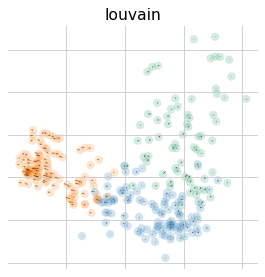

WSSS_PLA8764122


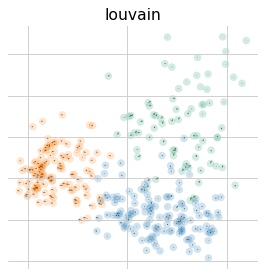

WSSS_PLA8810750


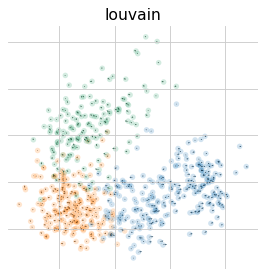

WSSS_PLA8810751


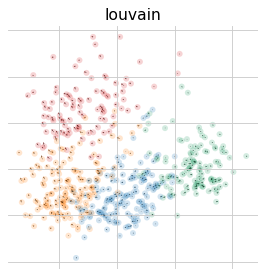

In [183]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.pl.velocity_embedding(adatas_loom[sample], basis='pca')

In [184]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.tl.terminal_states(adatas_loom[sample]) # rerun

WSSS_PLA8764121
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8764122
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8810750
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8810751
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', 

In [185]:
adata_loom.obs.columns

Index(['sample'], dtype='object')

WSSS_PLA8764121


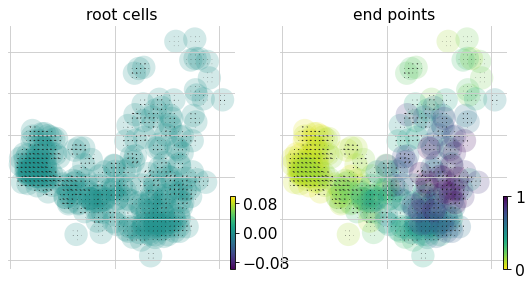

WSSS_PLA8764122


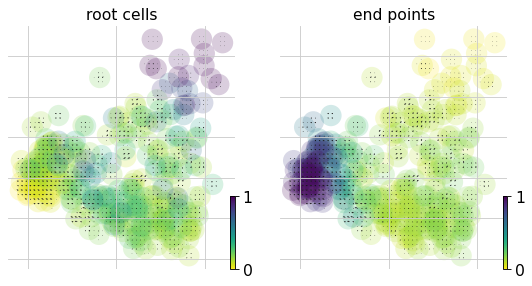

WSSS_PLA8810750


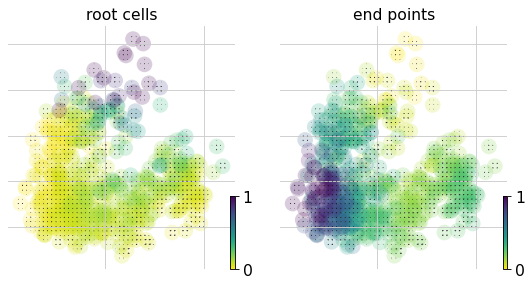

WSSS_PLA8810751


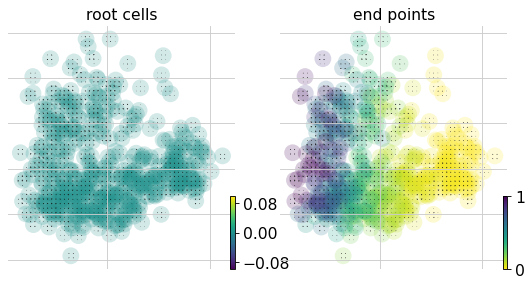

In [186]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.pl.velocity_embedding_grid(adatas_loom[sample], 
                                   basis='pca', color=['root_cells', 'end_points'])

In [188]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    # are the indices in the same order?
    print(np.unique(adata[adata.obs['sample'] == sample].obs['barcode_sample'] == adatas_loom[sample].obs.index))

WSSS_PLA8764121
[ True]
WSSS_PLA8764122
[ True]
WSSS_PLA8810750
[ True]
WSSS_PLA8810751
[ True]


In [189]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    adatas_loom[sample].obsm['X_umap'] = adata[adata.obs['sample'] == sample].obsm['X_umap']

WSSS_PLA8764121
WSSS_PLA8764122
WSSS_PLA8810750
WSSS_PLA8810751


In [191]:
adatas_loom['WSSS_PLA8764121']

AnnData object with n_obs × n_vars = 272 × 2954
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain', 'root_cells', 'end_points'
    var: 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'velocity_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [192]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.tl.velocity_embedding(adatas_loom[sample], basis='umap')

Trying to set attribute `.obsm` of view, copying.


WSSS_PLA8764121
computing velocity embedding


IndexError: boolean index did not match indexed array along dimension 0; dimension is 272 but corresponding boolean dimension is 84

In [107]:
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.tl.terminal_states(adatas_loom[sample])

WSSS_PLA8764121
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8764122
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8810750
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
WSSS_PLA8810751
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', 

In [108]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
for sample in np.unique(adata_loom.obs['sample']):
    print(sample)
    scv.pl.velocity_embedding_grid(adatas_loom[sample], basis='umap', color=['root_cells', 'end_points'])

Trying to set attribute `.obsm` of view, copying.


WSSS_PLA8764121
computing velocity embedding


IndexError: boolean index did not match indexed array along dimension 0; dimension is 272 but corresponding boolean dimension is 84

In [144]:
scv.tl.umap(adata_loom)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:49) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


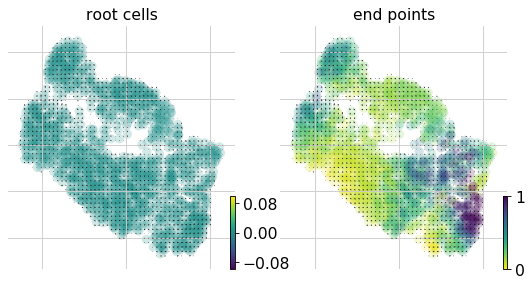

In [145]:
scv.tl.velocity_embedding(adata_loom, basis='umap')
scv.tl.terminal_states(adata_loom)
scv.pl.velocity_embedding_grid(adata_loom, basis='umap', color=['root_cells', 'end_points'])

In [146]:
adata_loom.obs

n_counts_spliced  n_counts_unspliced  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121               708                4643   
AACACACCACTGAGGA-1_WSSS_PLA8764121               538                2588   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121               919                4928   
AACCATGCACTAAACC-1_WSSS_PLA8764121               514                3316   
AACCATGTCCAGCACG-1_WSSS_PLA8764121               344                1709   
...                                              ...                 ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751              1903                9059   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751              1007                5238   
TTTATGCCAGATACCT-1_WSSS_PLA8810751               784                4088   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751              1330                7496   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751               741                4294   

                                    initial_size_spliced  \
barcode_sample_sn_like                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                   708   
AACACACCACTGAGGA-1_WSSS_PLA8764121                   538   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                   919   
AACCATGCACTAAACC-1_WSSS_PLA8764121                   514   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                   344   
...                                                  ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                  1903   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                  1007   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                   784   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                  1330   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                   741   

                                    initial_size_unspliced  initial_size  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                    4643         708.0   
AACACACCACTGAGGA-1_WSSS_PLA8764121                    2588         538.0   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                    4928         919.0   
AACCATGCACTAAACC-1_WSSS_PLA8764121                    3316         514.0   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                    1709         344.0   
...                                                    ...           ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                    9059        1903.0   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                    5238        1007.0   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                    4088         784.0   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                    7496        1330.0   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                    4294         741.0   

                                      n_counts  velocity_self_transition  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121  862.067810                  0.077434   
AACACACCACTGAGGA-1_WSSS_PLA8764121  844.293579                  0.348836   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121  856.087036                  0.131639   
AACCATGCACTAAACC-1_WSSS_PLA8764121  847.681030                  0.246179   
AACCATGTCCAGCACG-1_WSSS_PLA8764121  838.412842                  0.176096   
...                                        ...                       ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751  866.705200                  0.215555   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751  853.096313                  0.088361   
TTTATGCCAGATACCT-1_WSSS_PLA8810751  869.625000                  0.090821   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751  858.789368                  0.167634   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751  855.813843                  0.207655   

                                   louvain  root_cells  end_points  
barcode_sample_sn_like                                              
AACAACCAGTCCTGCG-1_WSSS_PLA8764121       2         0.0    0.361075  
AACACACCACTGAGGA-1_WSSS_PLA8764121       4         0.0    0.379664  
AACCAACAGGTG

In [147]:
adata.obs['root_cells_velocyto'] = list(adata_loom.obs['root_cells'])
adata.obs['end_points_velocyto'] = list(adata_loom.obs['end_points'])

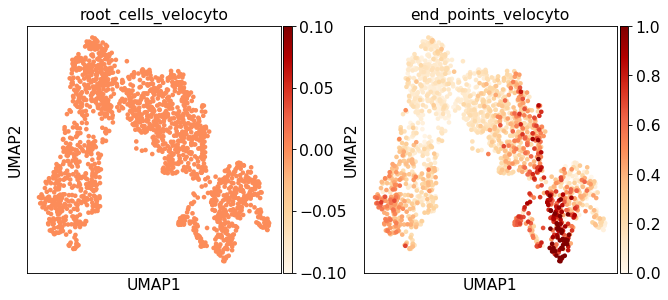

In [148]:
sc.pl.umap(adata, color=['root_cells_velocyto','end_points_velocyto'], cmap='OrRd')

In [149]:
adata_loom.obs

n_counts_spliced  n_counts_unspliced  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121               708                4643   
AACACACCACTGAGGA-1_WSSS_PLA8764121               538                2588   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121               919                4928   
AACCATGCACTAAACC-1_WSSS_PLA8764121               514                3316   
AACCATGTCCAGCACG-1_WSSS_PLA8764121               344                1709   
...                                              ...                 ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751              1903                9059   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751              1007                5238   
TTTATGCCAGATACCT-1_WSSS_PLA8810751               784                4088   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751              1330                7496   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751               741                4294   

                                    initial_size_spliced  \
barcode_sample_sn_like                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                   708   
AACACACCACTGAGGA-1_WSSS_PLA8764121                   538   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                   919   
AACCATGCACTAAACC-1_WSSS_PLA8764121                   514   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                   344   
...                                                  ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                  1903   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                  1007   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                   784   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                  1330   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                   741   

                                    initial_size_unspliced  initial_size  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121                    4643         708.0   
AACACACCACTGAGGA-1_WSSS_PLA8764121                    2588         538.0   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121                    4928         919.0   
AACCATGCACTAAACC-1_WSSS_PLA8764121                    3316         514.0   
AACCATGTCCAGCACG-1_WSSS_PLA8764121                    1709         344.0   
...                                                    ...           ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751                    9059        1903.0   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751                    5238        1007.0   
TTTATGCCAGATACCT-1_WSSS_PLA8810751                    4088         784.0   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751                    7496        1330.0   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751                    4294         741.0   

                                      n_counts  velocity_self_transition  \
barcode_sample_sn_like                                                     
AACAACCAGTCCTGCG-1_WSSS_PLA8764121  862.067810                  0.077434   
AACACACCACTGAGGA-1_WSSS_PLA8764121  844.293579                  0.348836   
AACCAACAGGTGGTTG-1_WSSS_PLA8764121  856.087036                  0.131639   
AACCATGCACTAAACC-1_WSSS_PLA8764121  847.681030                  0.246179   
AACCATGTCCAGCACG-1_WSSS_PLA8764121  838.412842                  0.176096   
...                                        ...                       ...   
TTTACTGCATTGTAGC-1_WSSS_PLA8810751  866.705200                  0.215555   
TTTACTGTCTGCATGA-1_WSSS_PLA8810751  853.096313                  0.088361   
TTTATGCCAGATACCT-1_WSSS_PLA8810751  869.625000                  0.090821   
TTTGACTCAGGAATAT-1_WSSS_PLA8810751  858.789368                  0.167634   
TTTGGAGTCCACAAGT-1_WSSS_PLA8810751  855.813843                  0.207655   

                                   louvain  root_cells  end_points  
barcode_sample_sn_like                                              
AACAACCAGTCCTGCG-1_WSSS_PLA8764121       2         0.0    0.361075  
AACACACCACTGAGGA-1_WSSS_PLA8764121       4         0.0    0.379664  
AACCAACAGGTG

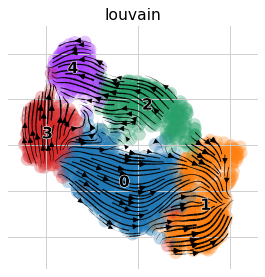

In [151]:
scv.pl.velocity_embedding_stream(adata_loom, basis='umap')


In [152]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 4000
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain', 'root_cells', 'end_points'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'velocity_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

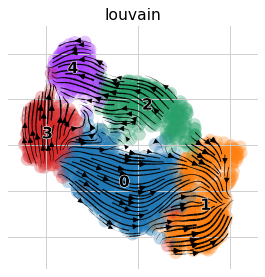

In [153]:
scv.pl.velocity_embedding_stream(adata_loom, basis='X_umap')


In [155]:
adata_loom.obs['cell_type'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'final_annot_inv_troph']

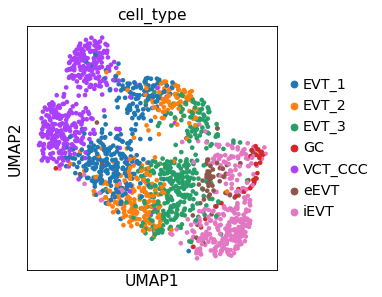

In [156]:
sc.pl.umap(adata_loom, color='cell_type')

In [160]:
adata_loom.obs['sample'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'sample']
adata_loom.obs['tissue_block'] = adata.obs.set_index('barcode_sample').loc[adata_loom.obs_names,'tissue_block']

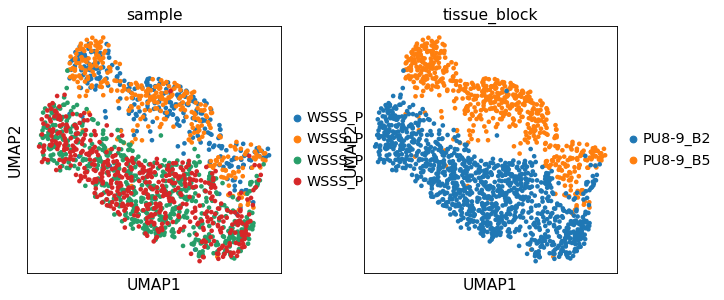

In [162]:
sc.pl.umap(adata_loom, color=['sample','tissue_block'])

In [163]:
adata_loom

AnnData object with n_obs × n_vars = 1729 × 4000
    obs: 'n_counts_spliced', 'n_counts_unspliced', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain', 'root_cells', 'end_points', 'cell_type', 'sample', 'tissue_block'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors', 'umap', 'cell_type_colors', 'sample_colors', 'tissue_block_colors'
    obsm: 'X_pca', 'velocity_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

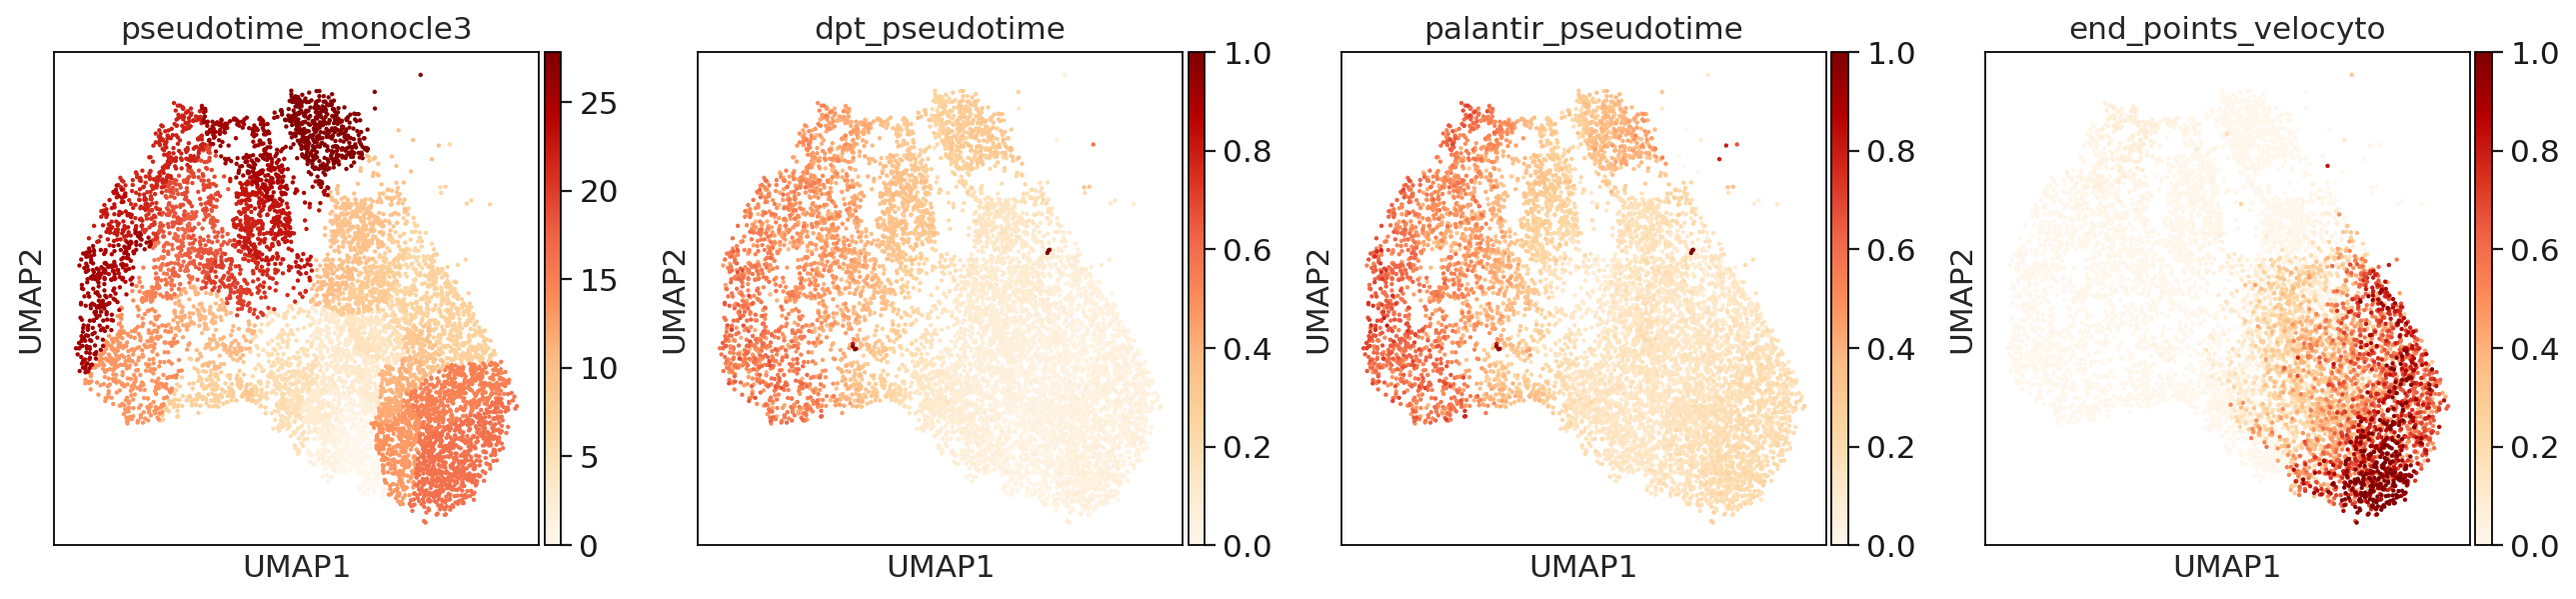

In [157]:
sc.pl.umap(adata,color=['pseudotime_monocle3','dpt_pseudotime','palantir_pseudotime','end_points_velocyto'], cmap='OrRd')

In [158]:
adata

AnnData object with n_obs × n_vars = 7764 × 4232 
    obs: 'batch', 'bh_pval', 'dataset', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'tissue', 'is_doublet', 'probabilities_sc', 'celltype_predictions_sc', 'probabilities_sn', 'celltype_predictions_sn', 'cell_id', 'annot_combined_logreg', 'annot_combined_logreg_final', 'louvain', 'is_doublet_poptrim', 'dpt_pseudotime', 'rootcell', 'palantir_pseudotime', 'pseudotime_monocle3', 'root_cells_velocyto', 'end_points_velocyto'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm

### Preparing the adata object for cellxgene

In [159]:
adata_full = anndata.AnnData(X=adata.raw.X,
                            obs=adata.obs,
                            var=adata.raw.var,
                            obsm=adata.obsm)

In [160]:
adata_full

AnnData object with n_obs × n_vars = 7764 × 21380 
    obs: 'batch', 'bh_pval', 'dataset', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'tissue', 'is_doublet', 'probabilities_sc', 'celltype_predictions_sc', 'probabilities_sn', 'celltype_predictions_sn', 'cell_id', 'annot_combined_logreg', 'annot_combined_logreg_final', 'louvain', 'is_doublet_poptrim', 'dpt_pseudotime', 'rootcell', 'palantir_pseudotime', 'pseudotime_monocle3', 'root_cells_velocyto', 'end_points_velocyto'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'

In [161]:
adata_full

AnnData object with n_obs × n_vars = 7764 × 21380 
    obs: 'batch', 'bh_pval', 'dataset', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'tissue', 'is_doublet', 'probabilities_sc', 'celltype_predictions_sc', 'probabilities_sn', 'celltype_predictions_sn', 'cell_id', 'annot_combined_logreg', 'annot_combined_logreg_final', 'louvain', 'is_doublet_poptrim', 'dpt_pseudotime', 'rootcell', 'palantir_pseudotime', 'pseudotime_monocle3', 'root_cells_velocyto', 'end_points_velocyto'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'

In [162]:
import scipy
adata_full.X = scipy.sparse.csc_matrix(adata_full.X)


In [163]:
categ_columns = ['batch', 'dataset', 'donor', 'sample', 'technique',
                 'tissue', 'is_doublet', 'celltype_predictions_sc',
                 'celltype_predictions_sn', 'cell_id', 'annot_combined_logreg',
                 'annot_combined_logreg_final', 'louvain', 'is_doublet_poptrim', 'rootcell',
                 ]

cont_columns = ['bh_pval', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'probabilities_sc',
                'probabilities_sn', 'dpt_pseudotime', 'palantir_pseudotime', 'pseudotime_monocle3', 'root_cells_velocyto', 'end_points_velocyto']


In [164]:
import pandas
for column in categ_columns:
    adata_full.obs[column] = pd.Categorical(adata_full.obs[column])
    
for column in cont_columns:
    adata_full.obs[column] = np.float32(adata_full.obs[column])

In [165]:
adata_full.write('donor_11_sc_sn_trajectories_final_cellxgene_troph.h5ad')

In [90]:
adata_full = sc.read('donor_11_sc_sn_trajectories_final_cellxgene_troph.h5ad')